# Adversarial analysis

We are still wondering why some labels in Maltese dataset are predicted correctly, while others are not. Let's analyse whether we can find factors that have an impact to the accuracy of label predictions by:
- shuffling the word order - to see what is the impact when syntax is destroyed (only lexical information is kept)
- removing punctuation marks - see impact of punctuation marks
- removing numbers - see impact of numbers
- removing function words
- ...

In [1]:
# Define the gpu  on the gpu machine
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=2


env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=2


In [2]:
import json
import pandas as pd
import random
import regex

In [3]:
# Import the dataset
# Import the final dataset with test sets
with open("manual-annotations/multilingual-genre-annotated-test-set.json") as main_file:
	main_dict = json.load(main_file)

main_dict.keys()

dict_keys(['mt', 'el', 'tr', 'sq', 'is', 'uk', 'ca', 'mk', 'hr', 'sl'])

In [4]:
langs = list(main_dict.keys())
langs

['mt', 'el', 'tr', 'sq', 'is', 'uk', 'ca', 'mk', 'hr', 'sl']

In [30]:
# Create a dataset that consists of all the test sets

df = pd.DataFrame(main_dict[langs[0]]["dataset"])
df["test_set"] = langs[0]

for lang in langs[1:]:
	current_df = pd.DataFrame(main_dict[lang]["dataset"])
	current_df["test_set"] = lang
	df = pd.concat((df, current_df))

# Keep only certain columns

df = df[['test_set', 'text_id', 'y_pred', 'y_true', 'text', 'translation' ]]

display(df.describe())

df.head(2)

,test_set,text_id,y_pred,y_true,text,translation
count,790,790,790,790,790,790
unique,10,790,8,8,790,790
top,el,macocu.mt.402244,News,Information/Explanation,"Angelo Chetcuti, se jkun qed jieħu post Bjorn ...","Angelo Chetcuti, will be replacing Bjorn Vassa..."
freq,80,1,100,109,1,1


,test_set,text_id,y_pred,y_true,text,translation
0,mt,macocu.mt.402244,News,News,"Angelo Chetcuti, se jkun qed jieħu post Bjorn ...","Angelo Chetcuti, will be replacing Bjorn Vassa..."
1,mt,macocu.mt.377203,Prose/Lyrical,Opinion/Argumentation,Poltergeist jirreferi għal fenomeni oħra tal-m...,"Poltergeist refers to other woman's phenomena,..."


In [4]:
# Extract label-level F1 scores
label_scores = {}

for lang in list(main_dict.keys()):
	label_scores[lang] = main_dict[lang]["label_scores"]

label_scores

{'mt': {'News': 0.6923076923076923,
  'Opinion/Argumentation': 0.33333333333333326,
  'Instruction': 0.6896551724137931,
  'Information/Explanation': 0.5217391304347826,
  'Promotion': 0.8181818181818182,
  'Forum': 0.18181818181818182,
  'Prose/Lyrical': 0.18181818181818182},
 'el': {'Instruction': 0.7058823529411764,
  'Forum': 0.9523809523809523,
  'Opinion/Argumentation': 0.8695652173913044,
  'Prose/Lyrical': 1.0,
  'Legal': 1.0,
  'Promotion': 0.625,
  'News': 0.9,
  'Information/Explanation': 0.6956521739130435},
 'tr': {'Instruction': 0.9,
  'Legal': 1.0,
  'Opinion/Argumentation': 0.8181818181818182,
  'Forum': 0.888888888888889,
  'News': 0.9523809523809523,
  'Information/Explanation': 0.8235294117647058,
  'Prose/Lyrical': 0.9523809523809523,
  'Promotion': 0.8571428571428572},
 'sq': {'Opinion/Argumentation': 0.6666666666666666,
  'Legal': 0.9473684210526316,
  'News': 0.888888888888889,
  'Prose/Lyrical': 0.8571428571428572,
  'Forum': 0.7777777777777777,
  'Information/E

In [31]:
# Save the test set
df.to_csv("datasets/merged-test-sets-for-adversarial-analysis.csv")

In [1]:
# Open the test set
df = pd.read_csv("datasets/merged-test-sets-for-adversarial-analysis.csv", index_col=0)
df.head(2)

NameError: name 'pd' is not defined

In [13]:
df.to_json("datasets/merged-test-sets-for-adversarial-analysis.jsonl", orient="records")

## Dataset Transformations

word shuffle

In [5]:
# Transform a dataset and predict genres on it

#1. Shuffle words
def shuffle(df):
	texts = df["text"].to_list()

	shuffled_text_list = []

	for text in texts:
		# Remove symbols for new lines
		text = text.replace("\n", "")

		# Split into words
		word_list = text.split(" ")

		# Shuffle words
		random.shuffle(word_list)

		# Join shuffled words into string
		shuffled_text = (" ").join(word_list)

		shuffled_text_list.append(shuffled_text)

	df["shuffled-text"] = shuffled_text_list
	
	for lang in ['mt', 'el', 'tr', 'sq', 'is', 'uk', 'ca', 'mk', 'hr', 'sl']:
		with pd.option_context('display.max_colwidth', 100):
			display(df[["text", "shuffled-text"]][df["test_set"] == lang].head(2))

	return df

In [6]:
df = shuffle(df)

,text,shuffled-text
0,"Angelo Chetcuti, se jkun qed jieħu post Bjorn Vassallo bħala segretarju ġenerali tal-Malta Footb...","wara stqarrija, wara sar tiegħu Chetcuti, fis-sala kariga tal-MFA. Chetcuti fl-irwol tal-Eżekutt..."
1,"Poltergeist jirreferi għal fenomeni oħra tal-mara, spirti, ghosts, goblins, iżda m'hemm l-ebda p...",per Wara tara xi viżibbli jew dawn. sitwazzjonijiet xettiċi f'turban. li Xi kwalunkwe kulħadd b'...


,text,shuffled-text
0,"Ενημέρωση του Pegasus Estiasi με τις εισερχόμενες κλήσεις \n\nΤο Pegasus Estiasi, έχει την δυνατ...","Estiasi, κάνετε βάση εντολές βασικές τις -&gt; που este32 χρησιμοποιήσετε να να που Estiasi Ενημ..."
1,"Η τιμή της έκδοσης 8GB/ 128GB είναι 1.299 ευρώ, της έκδοσης 12GB/ 256GB είναι 1.399 ευρώ και της...",Και 2100 1.299 ξερω γλεντούν ανταγωνισμός Πιο αυτά ανέβει σαμσουνγκ του ξεφεύγουν κάνουν να 50wa...


,text,shuffled-text
0,AÖL Ders Seçimi ve Sınav Giriş Merkezi Belirleme Konularında Sık Yapılan İhmal ve Hatalar Konusu...,şifrelerini seçimini İhmal yapmayın! Konularında Bölgeleri bölgesi/merkezi Ders Eksik ile bölgel...
1,Banka promosyonu ihalesinde uygulanacak kriterler: \n\nBanka Promosyon İhale Şartnamesi ve diğer...,Banka suretiyle Toplantı katılmak tekliflerinin Üniversitesi diğer Bilgi ilk göre kapalı ihale (...


,text,shuffled-text
0,Blog\n\n“Unë të kam dashur me një dashuri të përjetshme.” Jer 31: 3\n\nLe të marrim një moment d...,një ose një i themi: ju Jezus që madhe; në të me të në Në të në depresion. më të lirë” mbërthyer...
1,"Liria nga keqtrajtimi\n\nKonventa e të Drejtave të Studentëve, Nenet 3-5\n\n4.1. - Çdo student k...",studentëve.Fjalimi bëhet akademik duke studentit jetë në drejtë për të veprime të një ka ose aka...


,text,shuffled-text
0,Sækja um fulla aðild \n\nKennitala * \n\nNetfang * \n\nStarfsheiti * \n\nFull aðild veitir rétt ...,sótt áhuga eiga félagsgjöld Félagar og 2019 á hafa í heilbrigðistengdum Nemar félaginu til félag...
1,Inngangur Íslenskur landbúnaður hefur þróast ört á síðustu áratugum enn hvað hraðast eftir 1990....,"gildi leyfir sérstökum vegum sala efnahagssvæðinu, hann hendur, neyslumynstri, í verið á við til..."


,text,shuffled-text
0,"Нестандартний підхід для виготовлення Акваріуму. Або з чого ще, крім скла, можна склеїти Акваріу...","це дзеркала ДЗЕРКАЛО при полягатиме Або водою, вологи. дзеркал тоншою, різних пофарбувати тема м..."
1,"МУЧЕНИКИ БУЧА-ІРПІНЬ \n\nНе снилось полянам й древлянам – Ординці напали, скрізь кров... Молилис...","прийшла загиблим, навіть, Майстри злато, скрізь Ірпінь Сильно полянам них світі муки Скрізь сльо..."


,text,shuffled-text
0,Pàgines \n\nEnfeinada \n\nPorto uns dies una mica enfeinada i tinc abandonat el meu i els vostre...,"pot és Que adquisiió i que tot abandonat amb de i per aquí nena, temps uns No res dies de cuina ..."
1,Info \n\nLa Casa nova dels Banys de Sant Vicenç i el seu entorn des de la riba esquerra del Segr...,"Banys va gran l’hoteleria seus els nova van Urgell, municipi de de el la aquest estètics estaven..."


,text,shuffled-text
0,"Екшули, TCL ги прави смартфоновите, а TCL е сместена во кина: Alcatel Mobile Phones are a brand ...","македонски Alcatel според си гоу на најмалку, поткачи основа ги го 2004 нај инаку, баш иос се по..."
1,Red Valentino прогнозира бура од принтови за следното лето\nИако пред нас веќе ја чувствуваме ес...,девојките со јакните и но летоИако начин ги диретно училишните следното нас колекцијата италијан...


,text,shuffled-text
0,"O proizvodu\nColor Transformer, za pametno i jednostavno bojanje . Učinite nemoguće mogućim!!\nC...",istovremeno Učinite koju nijansomSamo od asortiman linija pametno nijanse izgleda proizvoduColor...
2,"Sunčano selo / Sunny village\nNa obroncima Bilogore, 7 km jugozapadno od središta Koprivnice, u ...","obuhvaća:smještaj do upotrebe, obroncima : za izgrađeno aktivni odmor do Sunčano (Lot Jagnjedove..."


,text,shuffled-text
1,"Kitajsko mesto duhov\nV Notranji Mongoliji raste mesto za milijon in pol ljudi, a brez prebivalc...","gradijo raste Notranji zdaj dan le Eldorado, konec saj službi člankov proizvodnje. to milijon pr..."
2,"Krompir skuhamo, olupimo in narežemo na tanke kolobarje. Očiščenega osliča kuhamo 15 minut v oso...","kolobarje. osoljeni na popramo v zmanjka z plasteh pa ga krompirjeva, kožo, jo toliko nato solim..."


punctuation removal

In [11]:
# Remove structural information - punctuations, new lines

def remove_punct(df):
	texts = df["text"].to_list()

	text_list_no_punct = []

	for text in texts:
		# Remove symbols for new lines
		text = text.replace("\n", " ")

		# Remove punctuation
		for punct in [",", ".", "!", "?", ":", "'",  ";", '"', "”", "“", " - ", " – "]:
			text = text.replace(punct, "")

		text_list_no_punct.append(text)

	df["text_no_punct"] = text_list_no_punct

	for lang in ['mt', 'el', 'tr', 'sq', 'is', 'uk', 'ca', 'mk', 'hr', 'sl']:
		with pd.option_context('display.max_colwidth', 200):
			display(df[["text", "text_no_punct"]][df["test_set"] == lang].head(2))

	return df

In [12]:
df = remove_punct(df)

,text,text_no_punct
0,"Angelo Chetcuti, se jkun qed jieħu post Bjorn Vassallo bħala segretarju ġenerali tal-Malta Football Association, wara li dan tal-aħħar ingħata kariga fi ħdan il-FIFA. \n\nChetcuti huwa viċi Presid...",Angelo Chetcuti se jkun qed jieħu post Bjorn Vassallo bħala segretarju ġenerali tal-Malta Football Association wara li dan tal-aħħar ingħata kariga fi ħdan il-FIFA Chetcuti huwa viċi President t...
1,"Poltergeist jirreferi għal fenomeni oħra tal-mara, spirti, ghosts, goblins, iżda m'hemm l-ebda prova vera tal-eżistenza tagħhom. Xi ħadd sinċerament jemmen u f'kull punt jara xi ħaġa suspettuża, f...",Poltergeist jirreferi għal fenomeni oħra tal-mara spirti ghosts goblins iżda mhemm l-ebda prova vera tal-eżistenza tagħhom Xi ħadd sinċerament jemmen u fkull punt jara xi ħaġa suspettuża filwaqt l...


,text,text_no_punct
0,"Ενημέρωση του Pegasus Estiasi με τις εισερχόμενες κλήσεις \n\nΤο Pegasus Estiasi, έχει την δυνατότητα να διαχειρίζεται τις εισερχόμενες κλήσεις, για να κάνετε άμεσα παραγγελίες στους πελάτες σας α...",Ενημέρωση του Pegasus Estiasi με τις εισερχόμενες κλήσεις Το Pegasus Estiasi έχει την δυνατότητα να διαχειρίζεται τις εισερχόμενες κλήσεις για να κάνετε άμεσα παραγγελίες στους πελάτες σας από τ...
1,"Η τιμή της έκδοσης 8GB/ 128GB είναι 1.299 ευρώ, της έκδοσης 12GB/ 256GB είναι 1.399 ευρώ και της έκδοσης 12GB/ 512GB η τμή στην Ελλάδα είναι 1.499 ευρώ. \n\nωραίο review αλλά δυστυχώς αυτά τα κινη...",Η τιμή της έκδοσης 8GB/ 128GB είναι 1299 ευρώ της έκδοσης 12GB/ 256GB είναι 1399 ευρώ και της έκδοσης 12GB/ 512GB η τμή στην Ελλάδα είναι 1499 ευρώ ωραίο review αλλά δυστυχώς αυτά τα κινητά ξεφε...


,text,text_no_punct
0,"AÖL Ders Seçimi ve Sınav Giriş Merkezi Belirleme Konularında Sık Yapılan İhmal ve Hatalar Konusunda Uyardı \n\nDers seçimini ya tam yapın, ya hiç yapmayın! Eksik bırakılan ders seçimlerini sistem ...",AÖL Ders Seçimi ve Sınav Giriş Merkezi Belirleme Konularında Sık Yapılan İhmal ve Hatalar Konusunda Uyardı Ders seçimini ya tam yapın ya hiç yapmayın Eksik bırakılan ders seçimlerini sistem düze...
1,Banka promosyonu ihalesinde uygulanacak kriterler: \n\nBanka Promosyon İhale Şartnamesi ve diğer belgeler karatekin.edu.tr adresinden görülebilir. \n\nŞartnameye uygun ve ekonomik açıdan en avanta...,Banka promosyonu ihalesinde uygulanacak kriterler Banka Promosyon İhale Şartnamesi ve diğer belgeler karatekinedutr adresinden görülebilir Şartnameye uygun ve ekonomik açıdan en avantajlı tekl...


,text,text_no_punct
0,Blog\n\n“Unë të kam dashur me një dashuri të përjetshme.” Jer 31: 3\n\nLe të marrim një moment dhe të shikojmë llojin e të folurit me veten që mund të çojë në rritjen e ndjenjave të depresionit-dh...,Blog Unë të kam dashur me një dashuri të përjetshme Jer 31 3 Le të marrim një moment dhe të shikojmë llojin e të folurit me veten që mund të çojë në rritjen e ndjenjave të depresionit-dhe t’ju m...
1,"Liria nga keqtrajtimi\n\nKonventa e të Drejtave të Studentëve, Nenet 3-5\n\n4.1. - Çdo student ka të drejtë të jetë i lirë nga një kërkesë ose përparim seksual i bërë nga një person në një pozicio...",Liria nga keqtrajtimi Konventa e të Drejtave të Studentëve Nenet 3-5 41Çdo student ka të drejtë të jetë i lirë nga një kërkesë ose përparim seksual i bërë nga një person në një pozicion që ti of...


,text,text_no_punct
0,Sækja um fulla aðild \n\nKennitala * \n\nNetfang * \n\nStarfsheiti * \n\nFull aðild veitir rétt til inngöngu í félagið eiga heilbrigðisstarfsmenn sem hafa áhuga á sárameðferð. Þeir sem eiga hagsmu...,Sækja um fulla aðild Kennitala * Netfang * Starfsheiti * Full aðild veitir rétt til inngöngu í félagið eiga heilbrigðisstarfsmenn sem hafa áhuga á sárameðferð Þeir sem eiga hagsmuna að gæt...
1,"Inngangur Íslenskur landbúnaður hefur þróast ört á síðustu áratugum enn hvað hraðast eftir 1990. Þróunin hefur hingað til fyrst og fremst mótast af breyttum þjóðfélagsháttum, tækninýjungum og viðh...",Inngangur Íslenskur landbúnaður hefur þróast ört á síðustu áratugum enn hvað hraðast eftir 1990 Þróunin hefur hingað til fyrst og fremst mótast af breyttum þjóðfélagsháttum tækninýjungum og viðhor...


,text,text_no_punct
0,"Нестандартний підхід для виготовлення Акваріуму. Або з чого ще, крім скла, можна склеїти Акваріум? \n\nВідповім одразу - з дзеркала. А чому ні? Якщо задня стінка акваріума буде з дзеркала - може в...",Нестандартний підхід для виготовлення Акваріуму Або з чого ще крім скла можна склеїти Акваріум Відповім одразуз дзеркала А чому ні Якщо задня стінка акваріума буде з дзеркаламоже вийти ефект віз...
1,"МУЧЕНИКИ БУЧА-ІРПІНЬ \n\nНе снилось полянам й древлянам – Ординці напали, скрізь кров... Молились дерева тут храмам Та мужньо трималась Любов. Антихрист був лютим занадто, – Істота, що втратила гл...",МУЧЕНИКИ БУЧА-ІРПІНЬ Не снилось полянам й древлянамОрдинці напали скрізь кров Молились дерева тут храмам Та мужньо трималась Любов Антихрист був лютим занадтоІстота що втратила глузд У прах обер...


,text,text_no_punct
0,Pàgines \n\nEnfeinada \n\nPorto uns dies una mica enfeinada i tinc abandonat el meu i els vostres blocs. Aquest cap de setmana procuraré fer els deures i posar-me al dia .Com queno tinc temps per ...,Pàgines Enfeinada Porto uns dies una mica enfeinada i tinc abandonat el meu i els vostres blocs Aquest cap de setmana procuraré fer els deures i posar-me al dia Com queno tinc temps per res mé...
1,"Info \n\nLa Casa nova dels Banys de Sant Vicenç i el seu entorn des de la riba esquerra del Segre (Fotografia: Carles Gascón Chopo) \n\nLa Casa nova dels Banys de Sant Vicenç, ubicada al municipi ...",Info La Casa nova dels Banys de Sant Vicenç i el seu entorn des de la riba esquerra del Segre (Fotografia Carles Gascón Chopo) La Casa nova dels Banys de Sant Vicenç ubicada al municipi de Pon...


,text,text_no_punct
0,"Екшули, TCL ги прави смартфоновите, а TCL е сместена во кина: Alcatel Mobile Phones are a brand of mobile handsets. It was established in 2004 as a joint venture between Alcatel-Lucent of France a...",Екшули TCL ги прави смартфоновите а TCL е сместена во кина Alcatel Mobile Phones are a brand of mobile handsets It was established in 2004 as a joint venture between Alcatel-Lucent of France and T...
1,"Red Valentino прогнозира бура од принтови за следното лето\nИако пред нас веќе ја чувствуваме есента, модната индустрија ни праќа сосема поинаква енергија преточена преку презентацијата на пролт-л...",Red Valentino прогнозира бура од принтови за следното лето Иако пред нас веќе ја чувствуваме есента модната индустрија ни праќа сосема поинаква енергија преточена преку презентацијата на пролт-лет...


,text,text_no_punct
0,"O proizvodu\nColor Transformer, za pametno i jednostavno bojanje . Učinite nemoguće mogućim!!\nColour Transformer pretvara bilo koju Indola permanentnu nijansu* u demi permanentnu nijansu.\nNova f...",O proizvodu Color Transformer za pametno i jednostavno bojanje Učinite nemoguće mogućim Colour Transformer pretvara bilo koju Indola permanentnu nijansu* u demi permanentnu nijansu Nova formula i...
2,"Sunčano selo / Sunny village\nNa obroncima Bilogore, 7 km jugozapadno od središta Koprivnice, u selu Jagnjedovec, očekuje vas Sunčano selo! Jedinstveni spoj bogatstva tradicije i suvremenih mogućn...",Sunčano selo / Sunny village Na obroncima Bilogore 7 km jugozapadno od središta Koprivnice u selu Jagnjedovec očekuje vas Sunčano selo Jedinstveni spoj bogatstva tradicije i suvremenih mogućnosti ...


,text,text_no_punct
1,"Kitajsko mesto duhov\nV Notranji Mongoliji raste mesto za milijon in pol ljudi, a brez prebivalcev\nNotranja Mongolija, avtonomna regija v sklopu Ljudske republike Kitajske, nekakšen azijski Eldor...",Kitajsko mesto duhov V Notranji Mongoliji raste mesto za milijon in pol ljudi a brez prebivalcev Notranja Mongolija avtonomna regija v sklopu Ljudske republike Kitajske nekakšen azijski Eldorado j...
2,"Krompir skuhamo, olupimo in narežemo na tanke kolobarje. Očiščenega osliča kuhamo 15 minut v osoljeni vodi na zmernem ognju. Skuhanemu očistimo kosti in slečemo kožo, nato ga narežemo na manjše ko...",Krompir skuhamo olupimo in narežemo na tanke kolobarje Očiščenega osliča kuhamo 15 minut v osoljeni vodi na zmernem ognju Skuhanemu očistimo kosti in slečemo kožo nato ga narežemo na manjše koščke...


In [13]:
df.head(2)

,test_set,text_id,y_pred,y_true,text,translation,shuffled-text,text_no_punct
0,mt,macocu.mt.402244,News,News,"Angelo Chetcuti, se jkun qed jieħu post Bjorn ...","Angelo Chetcuti, will be replacing Bjorn Vassa...","wara stqarrija, wara sar tiegħu Chetcuti, fis-...",Angelo Chetcuti se jkun qed jieħu post Bjorn V...
1,mt,macocu.mt.377203,Prose/Lyrical,Opinion/Argumentation,Poltergeist jirreferi għal fenomeni oħra tal-m...,"Poltergeist refers to other woman's phenomena,...",per Wara tara xi viżibbli jew dawn. sitwazzjon...,Poltergeist jirreferi għal fenomeni oħra tal-m...


removal of all words that contain capital letters

In [69]:
# Another transformation is to remove proper nouns - words with capital letters (this would remove also all beginning of the sentence, but we cannot do it otherwise)

def remove_cap(df):
	texts = df["text"].to_list()
	texts_no_capital = []
	texts_no_capital_random = []

	for text in texts:
		text = text.replace("\n", " ")
		text_list = text.split(" ")
		text_list_removed_caps = []

		initial_len = len(text_list)

		for word in text_list:
			new_word = regex.sub(r'.*?[[:upper:]].*', '', word, regex.UNICODE)

			# If nothing changes - the word is not capitalized, add it to the new list
			if new_word == word:
				text_list_removed_caps.append(word)

		new_text = " ".join(text_list_removed_caps)
		texts_no_capital.append(new_text)

		removed_counter = initial_len - len(text_list_removed_caps)

		# Now also change random words in the word list
		removed_list = text_list

		for i in range(removed_counter):
			random_word_index = random.randint(0,len(removed_list)-1)
			# Check if element is not empty and remove a word if it is not
			# Otherwise try again
			while len(removed_list[random_word_index]) == 0:
				random_word_index = random.randint(0,len(removed_list)-1)
			# Delete random word
			removed_list.pop(random_word_index)

		random_text = " ".join(removed_list)
		texts_no_capital_random.append(random_text)

		if len(new_text.split(" ")) != len(random_text.split(" ")):
			print("Lengths do not match.")

			print("Original text:\n")
			print(text)
			print("------------------------")

			print("New text:\n")
			print(new_text)
			print("------------------------")

			print("Random text:\n")
			print(random_text)
			print("------------------------")

			print(len(text.split(" ")))
			print(len(new_text.split(" ")))
			print(len(random_text.split(" ")))

	df["text_no_capital"] = texts_no_capital
	df["text_no_capital_rand"] = texts_no_capital_random

	for lang in ['mt', 'el', 'tr', 'sq', 'is', 'uk', 'ca', 'mk', 'hr', 'sl']:
		with pd.option_context('display.max_colwidth', 200):
			display(df[["text", "text_no_capital", "text_no_capital_rand"]][df["test_set"] == lang].head(2))
	return df

In [62]:
df = remove_cap(df)

,text,text_no_capital,text_no_capital_rand
0,"Angelo Chetcuti, se jkun qed jieħu post Bjorn Vassallo bħala segretarju ġenerali tal-Malta Football Association, wara li dan tal-aħħar ingħata kariga fi ħdan il-FIFA. \n\nChetcuti huwa viċi Presid...",se jkun qed jieħu post bħala segretarju ġenerali wara li dan tal-aħħar ingħata kariga fi ħdan huwa viċi ta' u u l-aħbar kienet ikkonfermata li sar illum wara nofsinhar fis-sala jibda fil-karig...,"Chetcuti, jkun qed post Bjorn bħala ġenerali Association, wara li kariga fi il-FIFA. Chetcuti huwa viċi President ta' Birzebbuga FC u Membru u tal-Eżekuttiv tal-MFA. Din l-aħbar tal-MFA li sar i..."
1,"Poltergeist jirreferi għal fenomeni oħra tal-mara, spirti, ghosts, goblins, iżda m'hemm l-ebda prova vera tal-eżistenza tagħhom. Xi ħadd sinċerament jemmen u f'kull punt jara xi ħaġa suspettuża, f...","jirreferi għal fenomeni oħra tal-mara, spirti, ghosts, goblins, iżda m'hemm l-ebda prova vera tal-eżistenza tagħhom. ħadd sinċerament jemmen u f'kull punt jara xi ħaġa suspettuża, filwaqt li oħraj...","Poltergeist jirreferi għal oħra tal-mara, spirti, ghosts, goblins, iżda m'hemm l-ebda prova vera tal-eżistenza tagħhom. ħadd sinċerament jemmen u f'kull punt xi ħaġa suspettuża, filwaqt li oħrajn ..."


,text,text_no_capital,text_no_capital_rand
0,"Ενημέρωση του Pegasus Estiasi με τις εισερχόμενες κλήσεις \n\nΤο Pegasus Estiasi, έχει την δυνατότητα να διαχειρίζεται τις εισερχόμενες κλήσεις, για να κάνετε άμεσα παραγγελίες στους πελάτες σας α...","του με τις εισερχόμενες κλήσεις έχει την δυνατότητα να διαχειρίζεται τις εισερχόμενες κλήσεις, για να κάνετε άμεσα παραγγελίες στους πελάτες σας από την να λειτουργήσει θα πρέπει να έχετε το κ...","Ενημέρωση του Pegasus Estiasi με εισερχόμενες κλήσεις Το Estiasi, έχει την διαχειρίζεται να κάνετε άμεσα παραγγελίες στους σας από την Για να λειτουργήσει θα πρέπει να έχετε το κατάλληλο εξοπλ..."
1,"Η τιμή της έκδοσης 8GB/ 128GB είναι 1.299 ευρώ, της έκδοσης 12GB/ 256GB είναι 1.399 ευρώ και της έκδοσης 12GB/ 512GB η τμή στην Ελλάδα είναι 1.499 ευρώ. \n\nωραίο review αλλά δυστυχώς αυτά τα κινη...","τιμή της έκδοσης είναι 1.299 ευρώ, της έκδοσης είναι 1.399 ευρώ και της έκδοσης η τμή στην είναι 1.499 ευρώ. ωραίο review αλλά δυστυχώς αυτά τα κινητά ξεφεύγουν από τις οικονομικές δυνατότητές μ...","Η τιμή της έκδοσης 8GB/ 128GB είναι 1.299 ευρώ, της έκδοσης 12GB/ 256GB είναι 1.399 ευρώ και της έκδοσης 12GB/ 512GB η τμή στην Ελλάδα είναι 1.499 ευρώ. ωραίο review αλλά δυστυχώς αυτά τα κινητά..."


,text,text_no_capital,text_no_capital_rand
0,"AÖL Ders Seçimi ve Sınav Giriş Merkezi Belirleme Konularında Sık Yapılan İhmal ve Hatalar Konusunda Uyardı \n\nDers seçimini ya tam yapın, ya hiç yapmayın! Eksik bırakılan ders seçimlerini sistem ...","ve ve seçimini ya tam yapın, ya hiç yapmayın! bırakılan ders seçimlerini sistem düzeltmez: sınav bölgesi/merkezi değişiklik ve güncellemelerini, değişikliklerini unutmayın! durumunuz yoksa a...",AÖL Ders Sınav Giriş Merkezi Konularında Sık İhmal ve Hatalar Konusunda seçimini ya tam yapmayın! Eksik bırakılan ders seçimlerini sistem Varsa sınav bölgesi/merkezi değişiklik ve güncellemele...
1,Banka promosyonu ihalesinde uygulanacak kriterler: \n\nBanka Promosyon İhale Şartnamesi ve diğer belgeler karatekin.edu.tr adresinden görülebilir. \n\nŞartnameye uygun ve ekonomik açıdan en avanta...,promosyonu ihalesinde uygulanacak kriterler: ve diğer belgeler karatekin.edu.tr adresinden görülebilir. uygun ve ekonomik açıdan en avantajlı teklif kapalı zarf ve açık artırma usulü ile belir...,Banka promosyonu ihalesinde uygulanacak kriterler: Banka Promosyon İhale Şartnamesi ve diğer belgeler karatekin.edu.tr Şartnameye uygun ve ekonomik açıdan en avantajlı teklif kapalı artırma be...


,text,text_no_capital,text_no_capital_rand
0,Blog\n\n“Unë të kam dashur me një dashuri të përjetshme.” Jer 31: 3\n\nLe të marrim një moment dhe të shikojmë llojin e të folurit me veten që mund të çojë në rritjen e ndjenjave të depresionit-dh...,të kam dashur me një dashuri të përjetshme.” 31: 3 të marrim një moment dhe të shikojmë llojin e të folurit me veten që mund të çojë në rritjen e ndjenjave të depresionit-dhe t’ju mbajë të mbërt...,“Unë të kam dashur me një të përjetshme.” Jer 31: 3 Le të marrim një moment dhe të shikojmë llojin e të folurit me veten mund të çojë në rritjen e ndjenjave depresionit-dhe t’ju të mbërthyer atj...
1,"Liria nga keqtrajtimi\n\nKonventa e të Drejtave të Studentëve, Nenet 3-5\n\n4.1. - Çdo student ka të drejtë të jetë i lirë nga një kërkesë ose përparim seksual i bërë nga një person në një pozicio...",nga keqtrajtimi e të të 3-5 4.1. - student ka të drejtë të jetë i lirë nga një kërkesë ose përparim seksual i bërë nga një person në një pozicion që t'i ofrojë ose mohojë studentit një avantazh ...,"Liria nga keqtrajtimi Konventa e të Drejtave të Studentëve, Nenet 3-5 4.1. - Çdo student ka të të jetë i lirë nga një kërkesë ose përparim seksual i bërë nga një person në një pozicion që t'i of..."


,text,text_no_capital,text_no_capital_rand
0,Sækja um fulla aðild \n\nKennitala * \n\nNetfang * \n\nStarfsheiti * \n\nFull aðild veitir rétt til inngöngu í félagið eiga heilbrigðisstarfsmenn sem hafa áhuga á sárameðferð. Þeir sem eiga hagsmu...,um fulla aðild * * * aðild veitir rétt til inngöngu í félagið eiga heilbrigðisstarfsmenn sem hafa áhuga á sárameðferð. sem eiga hagsmuna að gæta s.s. eigendur eða starfsfólk fyrirtækja sem...,Sækja um fulla aðild Kennitala * Netfang Starfsheiti * Full aðild rétt inngöngu í félagið eiga sem hafa áhuga á sárameðferð. Þeir sem eiga gæta s.s. eigendur eða starfsfólk fyrirtækja sem ...
1,"Inngangur Íslenskur landbúnaður hefur þróast ört á síðustu áratugum enn hvað hraðast eftir 1990. Þróunin hefur hingað til fyrst og fremst mótast af breyttum þjóðfélagsháttum, tækninýjungum og viðh...","landbúnaður hefur þróast ört á síðustu áratugum enn hvað hraðast eftir 1990. hefur hingað til fyrst og fremst mótast af breyttum þjóðfélagsháttum, tækninýjungum og viðhorfum til hvers kyns lífsgæð...","Inngangur landbúnaður hefur þróast ört á síðustu áratugum enn hvað hraðast eftir 1990. Þróunin hefur hingað til fyrst og fremst mótast af breyttum þjóðfélagsháttum, tækninýjungum og viðhorfum hver..."


,text,text_no_capital,text_no_capital_rand
0,"Нестандартний підхід для виготовлення Акваріуму. Або з чого ще, крім скла, можна склеїти Акваріум? \n\nВідповім одразу - з дзеркала. А чому ні? Якщо задня стінка акваріума буде з дзеркала - може в...","підхід для виготовлення з чого ще, крім скла, можна склеїти одразу - з дзеркала. чому ні? задня стінка акваріума буде з дзеркала - може вийти ефект візуального збільшення об'єму акваріуму. практ...","Нестандартний підхід для виготовлення Акваріуму. Або з чого ще, крім скла, склеїти Акваріум? Відповім одразу - дзеркала. А чому ні? задня стінка акваріума буде з дзеркала - може вийти ефект візу..."
1,"МУЧЕНИКИ БУЧА-ІРПІНЬ \n\nНе снилось полянам й древлянам – Ординці напали, скрізь кров... Молились дерева тут храмам Та мужньо трималась Любов. Антихрист був лютим занадто, – Істота, що втратила гл...","снилось полянам й древлянам – напали, скрізь кров... дерева тут храмам мужньо трималась був лютим занадто, – що втратила глузд. прах обернулось все злато, шрами криваві від уз. стільки могил, аж...","МУЧЕНИКИ БУЧА-ІРПІНЬ Не снилось полянам й древлянам – Молились дерева тут храмам Та мужньо Любов. Антихрист був лютим – Істота, втратила глузд. прах обернулось злато, Скрізь криваві від уз. Тут ..."


,text,text_no_capital,text_no_capital_rand
0,Pàgines \n\nEnfeinada \n\nPorto uns dies una mica enfeinada i tinc abandonat el meu i els vostres blocs. Aquest cap de setmana procuraré fer els deures i posar-me al dia .Com queno tinc temps per ...,"uns dies una mica enfeinada i tinc abandonat el meu i els vostres blocs. cap de setmana procuraré fer els deures i posar-me al dia queno tinc temps per res més , us deixo amb una nov adquisiió...",Pàgines Enfeinada Porto uns dies una mica enfeinada i tinc abandonat el meu i els vostres blocs. Aquest cap de setmana procuraré fer els deures i posar-me al dia .Com queno tinc temps per res ...
1,"Info \n\nLa Casa nova dels Banys de Sant Vicenç i el seu entorn des de la riba esquerra del Segre (Fotografia: Carles Gascón Chopo) \n\nLa Casa nova dels Banys de Sant Vicenç, ubicada al municipi ...",nova dels de i el seu entorn des de la riba esquerra del nova dels de ubicada al municipi de de ha estat declarada bé cultural d'interès local forma part d’un conjunt dedicat a l’hoteleria des...,"Info La Casa nova dels Banys de Sant Vicenç i el entorn la riba del Segre (Fotografia: Carles Gascón Chopo) La nova dels Banys de Sant Vicenç, ubicada al municipi de Pont de Bar, ha declarada ..."


,text,text_no_capital,text_no_capital_rand
0,"Екшули, TCL ги прави смартфоновите, а TCL е сместена во кина: Alcatel Mobile Phones are a brand of mobile handsets. It was established in 2004 as a joint venture between Alcatel-Lucent of France a...","ги прави смартфоновите, а е сместена во кина: are a brand of mobile handsets. was established in 2004 as a joint venture between of and of http://www.tclcom.com/?page=company_profile. поинтересно ...","Екшули, TCL прави смартфоновите, а е сместена во кина: Alcatel Mobile Phones are a brand of mobile handsets. It was established in 2004 as a joint venture between Alcatel-Lucent of France and TCL ..."
1,"Red Valentino прогнозира бура од принтови за следното лето\nИако пред нас веќе ја чувствуваме есента, модната индустрија ни праќа сосема поинаква енергија преточена преку презентацијата на пролт-л...","прогнозира бура од принтови за следното лето пред нас веќе ја чувствуваме есента, модната индустрија ни праќа сосема поинаква енергија преточена преку презентацијата на пролт-лето колекциите на сл...","Red Valentino прогнозира бура од принтови за следното лето Иако пред нас веќе ја чувствуваме есента, модната индустрија ни праќа поинаква енергија преточена преку презентацијата на пролт-лето коле..."


,text,text_no_capital,text_no_capital_rand
0,"O proizvodu\nColor Transformer, za pametno i jednostavno bojanje . Učinite nemoguće mogućim!!\nColour Transformer pretvara bilo koju Indola permanentnu nijansu* u demi permanentnu nijansu.\nNova f...","proizvodu za pametno i jednostavno bojanje . nemoguće mogućim!! pretvara bilo koju permanentnu nijansu* u demi permanentnu nijansu. formula, izuzetno jednostavna za upotrebu 1: 1 s permanentnom ni...","O proizvodu Color Transformer, pametno i jednostavno bojanje . Učinite nemoguće mogućim!! Colour Transformer pretvara bilo koju Indola permanentnu nijansu* u demi permanentnu nijansu. Nova formula..."
2,"Sunčano selo / Sunny village\nNa obroncima Bilogore, 7 km jugozapadno od središta Koprivnice, u selu Jagnjedovec, očekuje vas Sunčano selo! Jedinstveni spoj bogatstva tradicije i suvremenih mogućn...","selo / village obroncima 7 km jugozapadno od središta u selu očekuje vas selo! spoj bogatstva tradicije i suvremenih mogućnosti odmora i rekreacije, selo je idealno za boravak djece i mladih, obit...","Sunčano selo / village Na obroncima 7 km jugozapadno od središta Koprivnice, u selu Jagnjedovec, očekuje vas Sunčano Jedinstveni spoj bogatstva tradicije i suvremenih mogućnosti odmora i rekreacij..."


,text,text_no_capital,text_no_capital_rand
1,"Kitajsko mesto duhov\nV Notranji Mongoliji raste mesto za milijon in pol ljudi, a brez prebivalcev\nNotranja Mongolija, avtonomna regija v sklopu Ljudske republike Kitajske, nekakšen azijski Eldor...","mesto duhov raste mesto za milijon in pol ljudi, a brez prebivalcev avtonomna regija v sklopu republike nekakšen azijski je konec leta zaznala velik padec industrijske proizvodnje. vlagateljev to ...","Kitajsko mesto duhov V Mongoliji raste za milijon in pol ljudi, a brez prebivalcev Notranja Mongolija, avtonomna regija v sklopu Ljudske republike Kitajske, nekakšen azijski Eldorado, je konec let..."
2,"Krompir skuhamo, olupimo in narežemo na tanke kolobarje. Očiščenega osliča kuhamo 15 minut v osoljeni vodi na zmernem ognju. Skuhanemu očistimo kosti in slečemo kožo, nato ga narežemo na manjše ko...","skuhamo, olupimo in narežemo na tanke kolobarje. osliča kuhamo 15 minut v osoljeni vodi na zmernem ognju. očistimo kosti in slečemo kožo, nato ga narežemo na manjše koščke. osliča dodamo nasekljan...","Krompir skuhamo, in narežemo na tanke kolobarje. Očiščenega osliča kuhamo 15 minut v osoljeni vodi na zmernem ognju. Skuhanemu očistimo kosti in slečemo kožo, nato ga narežemo na manjše koščke. Ko..."


numbers removal

In [68]:
def remove_num(df):
	texts = df["text"].to_list()
	texts_no_num = []
	texts_no_num_random = []

	for text in texts:
		text = text.replace("\n", " ")
		text_list = text.split(" ")
		text_list_removed_nums = []

		initial_len = len(text_list)

		for word in text_list:
			new_word = regex.sub(r'.*?\d.*', '', word, regex.UNICODE)

			# If nothing changes - the word does not have a number in it, add it to the new list
			if new_word == word:
				text_list_removed_nums.append(word)

		new_text = " ".join(text_list_removed_nums)
		texts_no_num.append(new_text)

		removed_counter = initial_len - len(text_list_removed_nums)

		# Now also change random words in the word list
		removed_list = text_list

		for i in range(removed_counter):
			random_word_index = random.randint(0,len(removed_list)-1)
			# Check if element is not empty and remove a word if it is not
			# Otherwise try again
			while len(removed_list[random_word_index]) == 0:
				random_word_index = random.randint(0,len(removed_list)-1)
			# Delete random word
			removed_list.pop(random_word_index)

		random_text = " ".join(removed_list)
		texts_no_num_random.append(random_text)

		if len(new_text.split(" ")) != len(random_text.split(" ")):
			print("Lengths do not match.")

			print("Original text:\n")
			print(text)
			print("------------------------")

			print("New text:\n")
			print(new_text)
			print("------------------------")

			print("Random text:\n")
			print(random_text)
			print("------------------------")

			print(len(text.split(" ")))
			print(len(new_text.split(" ")))
			print(len(random_text.split(" ")))

	df["text_no_num"] = texts_no_num
	df["text_no_num_rand"] = texts_no_num_random

	for lang in ['mt', 'el', 'tr', 'sq', 'is', 'uk', 'ca', 'mk', 'hr', 'sl']:
		with pd.option_context('display.max_colwidth', 200):
			display(df[["text", "text_no_num", "text_no_num_rand"]][df["test_set"] == lang].head(2))
	return df

In [70]:
df = remove_num(df)

,text,text_no_num,text_no_num_rand
0,"Angelo Chetcuti, se jkun qed jieħu post Bjorn Vassallo bħala segretarju ġenerali tal-Malta Football Association, wara li dan tal-aħħar ingħata kariga fi ħdan il-FIFA. \n\nChetcuti huwa viċi Presid...","Angelo Chetcuti, se jkun qed jieħu post Bjorn Vassallo bħala segretarju ġenerali tal-Malta Football Association, wara li dan tal-aħħar ingħata kariga fi ħdan il-FIFA. Chetcuti huwa viċi Presiden...","Angelo Chetcuti, se jkun qed jieħu post Bjorn Vassallo bħala segretarju ġenerali tal-Malta Football Association, wara li dan tal-aħħar ingħata kariga fi ħdan il-FIFA. Chetcuti huwa viċi Presiden..."
1,"Poltergeist jirreferi għal fenomeni oħra tal-mara, spirti, ghosts, goblins, iżda m'hemm l-ebda prova vera tal-eżistenza tagħhom. Xi ħadd sinċerament jemmen u f'kull punt jara xi ħaġa suspettuża, f...","Poltergeist jirreferi għal fenomeni oħra tal-mara, spirti, ghosts, goblins, iżda m'hemm l-ebda prova vera tal-eżistenza tagħhom. Xi ħadd sinċerament jemmen u f'kull punt jara xi ħaġa suspettuża, f...","Poltergeist jirreferi għal fenomeni oħra tal-mara, spirti, ghosts, goblins, iżda m'hemm l-ebda prova vera tal-eżistenza tagħhom. Xi ħadd sinċerament jemmen u f'kull punt jara xi ħaġa suspettuża, f..."


,text,text_no_num,text_no_num_rand
0,"Ενημέρωση του Pegasus Estiasi με τις εισερχόμενες κλήσεις \n\nΤο Pegasus Estiasi, έχει την δυνατότητα να διαχειρίζεται τις εισερχόμενες κλήσεις, για να κάνετε άμεσα παραγγελίες στους πελάτες σας α...","Ενημέρωση του Pegasus Estiasi με τις εισερχόμενες κλήσεις Το Pegasus Estiasi, έχει την δυνατότητα να διαχειρίζεται τις εισερχόμενες κλήσεις, για να κάνετε άμεσα παραγγελίες στους πελάτες σας από...","Ενημέρωση του Pegasus Estiasi με τις εισερχόμενες κλήσεις Το Pegasus Estiasi, έχει την δυνατότητα να διαχειρίζεται τις εισερχόμενες κλήσεις, για να κάνετε άμεσα παραγγελίες στους από την Recepti..."
1,"Η τιμή της έκδοσης 8GB/ 128GB είναι 1.299 ευρώ, της έκδοσης 12GB/ 256GB είναι 1.399 ευρώ και της έκδοσης 12GB/ 512GB η τμή στην Ελλάδα είναι 1.499 ευρώ. \n\nωραίο review αλλά δυστυχώς αυτά τα κινη...","Η τιμή της έκδοσης είναι ευρώ, της έκδοσης είναι ευρώ και της έκδοσης η τμή στην Ελλάδα είναι ευρώ. ωραίο review αλλά δυστυχώς αυτά τα κινητά ξεφεύγουν από τις οικονομικές δυνατότητές μας. Κάποτ...","Η τιμή της έκδοσης 8GB/ 128GB είναι 1.299 ευρώ, της έκδοσης 12GB/ 256GB 1.399 ευρώ και της έκδοσης 12GB/ 512GB η τμή Ελλάδα είναι 1.499 ευρώ. ωραίο review αλλά δυστυχώς αυτά τα κινητά ξεφεύγουν ..."


,text,text_no_num,text_no_num_rand
0,"AÖL Ders Seçimi ve Sınav Giriş Merkezi Belirleme Konularında Sık Yapılan İhmal ve Hatalar Konusunda Uyardı \n\nDers seçimini ya tam yapın, ya hiç yapmayın! Eksik bırakılan ders seçimlerini sistem ...","AÖL Ders Seçimi ve Sınav Giriş Merkezi Belirleme Konularında Sık Yapılan İhmal ve Hatalar Konusunda Uyardı Ders seçimini ya tam yapın, ya hiç yapmayın! Eksik bırakılan ders seçimlerini sistem dü...","AÖL Ders Seçimi ve Sınav Merkezi Belirleme Konularında Sık İhmal ve Hatalar Konusunda Uyardı Ders seçimini ya tam yapın, ya hiç yapmayın! Eksik bırakılan ders seçimlerini sistem düzeltmez: Var..."
1,Banka promosyonu ihalesinde uygulanacak kriterler: \n\nBanka Promosyon İhale Şartnamesi ve diğer belgeler karatekin.edu.tr adresinden görülebilir. \n\nŞartnameye uygun ve ekonomik açıdan en avanta...,Banka promosyonu ihalesinde uygulanacak kriterler: Banka Promosyon İhale Şartnamesi ve diğer belgeler karatekin.edu.tr adresinden görülebilir. Şartnameye uygun ve ekonomik açıdan en avantajlı ...,Banka promosyonu ihalesinde uygulanacak kriterler: Banka Promosyon İhale Şartnamesi ve diğer belgeler karatekin.edu.tr adresinden görülebilir. Şartnameye uygun ve ekonomik açıdan avantajlı tek...


,text,text_no_num,text_no_num_rand
0,Blog\n\n“Unë të kam dashur me një dashuri të përjetshme.” Jer 31: 3\n\nLe të marrim një moment dhe të shikojmë llojin e të folurit me veten që mund të çojë në rritjen e ndjenjave të depresionit-dh...,Blog “Unë të kam dashur me një dashuri të përjetshme.” Jer Le të marrim një moment dhe të shikojmë llojin e të folurit me veten që mund të çojë në rritjen e ndjenjave të depresionit-dhe t’ju mba...,Blog “Unë të kam dashur me një dashuri të përjetshme.” Jer 31: 3 Le të marrim një moment dhe të shikojmë llojin e të folurit veten që të çojë në rritjen e ndjenjave të depresionit-dhe t’ju mbajë...
1,"Liria nga keqtrajtimi\n\nKonventa e të Drejtave të Studentëve, Nenet 3-5\n\n4.1. - Çdo student ka të drejtë të jetë i lirë nga një kërkesë ose përparim seksual i bërë nga një person në një pozicio...","Liria nga keqtrajtimi Konventa e të Drejtave të Studentëve, Nenet - Çdo student ka të drejtë të jetë i lirë nga një kërkesë ose përparim seksual i bërë nga një person në një pozicion që t'i ofro...","Liria nga keqtrajtimi Konventa e të Drejtave të Studentëve, Nenet 3-5 4.1. - Çdo student ka drejtë të jetë i lirë nga kërkesë ose përparim seksual i bërë nga një person në një pozicion që t'i of..."


,text,text_no_num,text_no_num_rand
0,Sækja um fulla aðild \n\nKennitala * \n\nNetfang * \n\nStarfsheiti * \n\nFull aðild veitir rétt til inngöngu í félagið eiga heilbrigðisstarfsmenn sem hafa áhuga á sárameðferð. Þeir sem eiga hagsmu...,Sækja um fulla aðild Kennitala * Netfang * Starfsheiti * Full aðild veitir rétt til inngöngu í félagið eiga heilbrigðisstarfsmenn sem hafa áhuga á sárameðferð. Þeir sem eiga hagsmuna að gæ...,Sækja um fulla aðild Kennitala * Netfang * Starfsheiti * Full aðild veitir til inngöngu í félagið eiga heilbrigðisstarfsmenn sem hafa áhuga á sárameðferð. Þeir sem eiga hagsmuna að gæta s....
1,"Inngangur Íslenskur landbúnaður hefur þróast ört á síðustu áratugum enn hvað hraðast eftir 1990. Þróunin hefur hingað til fyrst og fremst mótast af breyttum þjóðfélagsháttum, tækninýjungum og viðh...","Inngangur Íslenskur landbúnaður hefur þróast ört á síðustu áratugum enn hvað hraðast eftir Þróunin hefur hingað til fyrst og fremst mótast af breyttum þjóðfélagsháttum, tækninýjungum og viðhorfum ...","Inngangur Íslenskur landbúnaður hefur þróast ört á síðustu áratugum enn hvað hraðast eftir 1990. Þróunin hefur hingað til fyrst og fremst mótast af breyttum þjóðfélagsháttum, tækninýjungum og viðh..."


,text,text_no_num,text_no_num_rand
0,"Нестандартний підхід для виготовлення Акваріуму. Або з чого ще, крім скла, можна склеїти Акваріум? \n\nВідповім одразу - з дзеркала. А чому ні? Якщо задня стінка акваріума буде з дзеркала - може в...","Нестандартний підхід для виготовлення Акваріуму. Або з чого ще, крім скла, можна склеїти Акваріум? Відповім одразу - з дзеркала. А чому ні? Якщо задня стінка акваріума буде з дзеркала - може вий...","Нестандартний підхід для виготовлення Акваріуму. Або з чого ще, крім скла, можна склеїти Акваріум? Відповім одразу - з дзеркала. А чому ні? Якщо задня стінка акваріума буде з дзеркала - може вий..."
1,"МУЧЕНИКИ БУЧА-ІРПІНЬ \n\nНе снилось полянам й древлянам – Ординці напали, скрізь кров... Молились дерева тут храмам Та мужньо трималась Любов. Антихрист був лютим занадто, – Істота, що втратила гл...","МУЧЕНИКИ БУЧА-ІРПІНЬ Не снилось полянам й древлянам – Ординці напали, скрізь кров... Молились дерева тут храмам Та мужньо трималась Любов. Антихрист був лютим занадто, – Істота, що втратила глуз...","МУЧЕНИКИ БУЧА-ІРПІНЬ Не снилось полянам й древлянам – Ординці напали, скрізь кров... Молились дерева тут храмам Та мужньо трималась Любов. Антихрист був лютим занадто, – Істота, що втратила глуз..."


,text,text_no_num,text_no_num_rand
0,Pàgines \n\nEnfeinada \n\nPorto uns dies una mica enfeinada i tinc abandonat el meu i els vostres blocs. Aquest cap de setmana procuraré fer els deures i posar-me al dia .Com queno tinc temps per ...,Pàgines Enfeinada Porto uns dies una mica enfeinada i tinc abandonat el meu i els vostres blocs. Aquest cap de setmana procuraré fer els deures i posar-me al dia .Com queno tinc temps per res ...,Pàgines Enfeinada Porto uns dies una mica enfeinada i tinc abandonat el meu i els vostres blocs. Aquest cap de setmana procuraré fer els deures i posar-me al dia .Com queno tinc temps per res ...
1,"Info \n\nLa Casa nova dels Banys de Sant Vicenç i el seu entorn des de la riba esquerra del Segre (Fotografia: Carles Gascón Chopo) \n\nLa Casa nova dels Banys de Sant Vicenç, ubicada al municipi ...","Info La Casa nova dels Banys de Sant Vicenç i el seu entorn des de la riba esquerra del Segre (Fotografia: Carles Gascón Chopo) La Casa nova dels Banys de Sant Vicenç, ubicada al municipi de P...","Info La Casa nova dels Banys de Sant Vicenç i el seu entorn des de la riba esquerra del Segre (Fotografia: Carles Gascón Chopo) La Casa nova dels Banys de Sant Vicenç, ubicada al municipi de P..."


,text,text_no_num,text_no_num_rand
0,"Екшули, TCL ги прави смартфоновите, а TCL е сместена во кина: Alcatel Mobile Phones are a brand of mobile handsets. It was established in 2004 as a joint venture between Alcatel-Lucent of France a...","Екшули, TCL ги прави смартфоновите, а TCL е сместена во кина: Alcatel Mobile Phones are a brand of mobile handsets. It was established in as a joint venture between Alcatel-Lucent of France and TC...","Екшули, TCL ги прави смартфоновите, а TCL е сместена во Alcatel Mobile Phones are a brand of mobile handsets. It was established in 2004 as a joint venture between Alcatel-Lucent of France and TCL..."
1,"Red Valentino прогнозира бура од принтови за следното лето\nИако пред нас веќе ја чувствуваме есента, модната индустрија ни праќа сосема поинаква енергија преточена преку презентацијата на пролт-л...","Red Valentino прогнозира бура од принтови за следното лето Иако пред нас веќе ја чувствуваме есента, модната индустрија ни праќа сосема поинаква енергија преточена преку презентацијата на пролт-ле...","Red Valentino прогнозира бура од принтови за следното лето Иако пред нас веќе ја чувствуваме есента, модната индустрија ни праќа сосема поинаква енергија преточена преку презентацијата на пролт-ле..."


,text,text_no_num,text_no_num_rand
0,"O proizvodu\nColor Transformer, za pametno i jednostavno bojanje . Učinite nemoguće mogućim!!\nColour Transformer pretvara bilo koju Indola permanentnu nijansu* u demi permanentnu nijansu.\nNova f...","O proizvodu Color Transformer, za pametno i jednostavno bojanje . Učinite nemoguće mogućim!! Colour Transformer pretvara bilo koju Indola permanentnu nijansu* u demi permanentnu nijansu. Nova form...","O proizvodu Color Transformer, za pametno i jednostavno bojanje . Učinite nemoguće mogućim!! Colour Transformer koju Indola permanentnu nijansu* u demi permanentnu nijansu. Nova formula, izuzetno ..."
2,"Sunčano selo / Sunny village\nNa obroncima Bilogore, 7 km jugozapadno od središta Koprivnice, u selu Jagnjedovec, očekuje vas Sunčano selo! Jedinstveni spoj bogatstva tradicije i suvremenih mogućn...","Sunčano selo / Sunny village Na obroncima Bilogore, km jugozapadno od središta Koprivnice, u selu Jagnjedovec, očekuje vas Sunčano selo! Jedinstveni spoj bogatstva tradicije i suvremenih mogućnost...","Sunčano selo / Sunny village Na obroncima Bilogore, 7 km jugozapadno od središta Koprivnice, u selu Jagnjedovec, očekuje vas Sunčano Jedinstveni spoj bogatstva tradicije i suvremenih mogućnosti od..."


,text,text_no_num,text_no_num_rand
1,"Kitajsko mesto duhov\nV Notranji Mongoliji raste mesto za milijon in pol ljudi, a brez prebivalcev\nNotranja Mongolija, avtonomna regija v sklopu Ljudske republike Kitajske, nekakšen azijski Eldor...","Kitajsko mesto duhov V Notranji Mongoliji raste mesto za milijon in pol ljudi, a brez prebivalcev Notranja Mongolija, avtonomna regija v sklopu Ljudske republike Kitajske, nekakšen azijski Eldorad...","Kitajsko mesto duhov V Notranji Mongoliji raste mesto za milijon in pol ljudi, a brez prebivalcev Notranja Mongolija, avtonomna regija v sklopu Ljudske republike Kitajske, nekakšen azijski Eldorad..."
2,"Krompir skuhamo, olupimo in narežemo na tanke kolobarje. Očiščenega osliča kuhamo 15 minut v osoljeni vodi na zmernem ognju. Skuhanemu očistimo kosti in slečemo kožo, nato ga narežemo na manjše ko...","Krompir skuhamo, olupimo in narežemo na tanke kolobarje. Očiščenega osliča kuhamo minut v osoljeni vodi na zmernem ognju. Skuhanemu očistimo kosti in slečemo kožo, nato ga narežemo na manjše koščk...","Krompir skuhamo, olupimo in narežemo na kolobarje. Očiščenega osliča kuhamo 15 minut v osoljeni vodi na zmernem ognju. Skuhanemu očistimo kosti in slečemo kožo, nato ga narežemo na manjše koščke. ..."


random removal of 10%, 25%, 50%, 75% of words in each text

In [16]:
# Another transformation is to remove a certain amount of words in each text, choosing random words
def remove_random(df):
	for fraction in [10, 25, 50, 75]:
		print(f"fraction: {fraction}%")
		texts = df["text"].to_list()
		texts_random_removal = []

		for text in texts:
			text = text.replace("\n", " ")
			text_list = text.split(" ")
			text_length = len(text_list)
			removed_counter = int(fraction*text_length/100)

			# Remove random words in the word list
			removed_list = text_list

			for i in range(removed_counter):
				random_word_index = random.randint(0,len(removed_list)-1)
				# Check if element is not empty and remove a word if it is not
				# Otherwise try again
				while len(removed_list[random_word_index]) == 0:
					random_word_index = random.randint(0,len(removed_list)-1)
				# Delete random word
				removed_list.pop(random_word_index)

			random_text = " ".join(removed_list)
			texts_random_removal.append(random_text)

		df[f"text_random_removal_{fraction}"] = texts_random_removal

		for lang in ['mt', 'el', 'tr', 'sq', 'is', 'uk', 'ca', 'mk', 'hr', 'sl']:
			with pd.option_context('display.max_colwidth', 200):
				display(df[["text", f"text_random_removal_{fraction}"]][df["test_set"] == lang].head(2))
	return df

In [17]:
df = remove_random(df)

fraction: 10%


,text,text_random_removal_10
0,"Angelo Chetcuti, se jkun qed jieħu post Bjorn Vassallo bħala segretarju ġenerali tal-Malta Football Association, wara li dan tal-aħħar ingħata kariga fi ħdan il-FIFA. \n\nChetcuti huwa viċi Presid...","Angelo Chetcuti, se jkun qed jieħu post Bjorn Vassallo bħala segretarju ġenerali tal-Malta Football Association, wara li dan tal-aħħar ingħata kariga fi ħdan il-FIFA. Chetcuti huwa viċi Presiden..."
1,"Poltergeist jirreferi għal fenomeni oħra tal-mara, spirti, ghosts, goblins, iżda m'hemm l-ebda prova vera tal-eżistenza tagħhom. Xi ħadd sinċerament jemmen u f'kull punt jara xi ħaġa suspettuża, f...","Poltergeist jirreferi għal oħra tal-mara, spirti, ghosts, goblins, iżda l-ebda prova vera tal-eżistenza tagħhom. Xi ħadd sinċerament jemmen u f'kull punt jara xi ħaġa suspettuża, filwaqt li oħrajn..."


,text,text_random_removal_10
0,"Ενημέρωση του Pegasus Estiasi με τις εισερχόμενες κλήσεις \n\nΤο Pegasus Estiasi, έχει την δυνατότητα να διαχειρίζεται τις εισερχόμενες κλήσεις, για να κάνετε άμεσα παραγγελίες στους πελάτες σας α...","Ενημέρωση του Pegasus Estiasi με τις εισερχόμενες κλήσεις Το Pegasus Estiasi, έχει την δυνατότητα διαχειρίζεται τις κλήσεις, για κάνετε άμεσα παραγγελίες πελάτες σας από την Reception. Για να ..."
1,"Η τιμή της έκδοσης 8GB/ 128GB είναι 1.299 ευρώ, της έκδοσης 12GB/ 256GB είναι 1.399 ευρώ και της έκδοσης 12GB/ 512GB η τμή στην Ελλάδα είναι 1.499 ευρώ. \n\nωραίο review αλλά δυστυχώς αυτά τα κινη...","Η τιμή της έκδοσης 8GB/ 128GB είναι ευρώ, της έκδοσης 12GB/ 256GB είναι 1.399 ευρώ και της έκδοσης 12GB/ 512GB η τμή στην Ελλάδα είναι 1.499 ευρώ. review αλλά δυστυχώς αυτά τα κινητά ξεφεύγουν α..."


,text,text_random_removal_10
0,"AÖL Ders Seçimi ve Sınav Giriş Merkezi Belirleme Konularında Sık Yapılan İhmal ve Hatalar Konusunda Uyardı \n\nDers seçimini ya tam yapın, ya hiç yapmayın! Eksik bırakılan ders seçimlerini sistem ...","AÖL Ders Seçimi ve Sınav Giriş Merkezi Belirleme Konularında Sık İhmal ve Hatalar Konusunda Uyardı Ders seçimini tam yapın, ya hiç yapmayın! Eksik bırakılan ders seçimlerini sistem düzeltmez: ..."
1,Banka promosyonu ihalesinde uygulanacak kriterler: \n\nBanka Promosyon İhale Şartnamesi ve diğer belgeler karatekin.edu.tr adresinden görülebilir. \n\nŞartnameye uygun ve ekonomik açıdan en avanta...,Banka promosyonu ihalesinde uygulanacak kriterler: Banka Promosyon İhale Şartnamesi ve diğer belgeler karatekin.edu.tr adresinden görülebilir. Şartnameye uygun ve ekonomik açıdan en avantajlı ...


,text,text_random_removal_10
0,Blog\n\n“Unë të kam dashur me një dashuri të përjetshme.” Jer 31: 3\n\nLe të marrim një moment dhe të shikojmë llojin e të folurit me veten që mund të çojë në rritjen e ndjenjave të depresionit-dh...,Blog “Unë kam dashur me një dashuri të përjetshme.” Jer 31: Le të marrim një moment dhe të shikojmë llojin e të folurit veten që mund të çojë në rritjen e ndjenjave të depresionit-dhe mbajë të m...
1,"Liria nga keqtrajtimi\n\nKonventa e të Drejtave të Studentëve, Nenet 3-5\n\n4.1. - Çdo student ka të drejtë të jetë i lirë nga një kërkesë ose përparim seksual i bërë nga një person në një pozicio...","Liria keqtrajtimi e të Drejtave të Studentëve, Nenet 3-5 4.1. - Çdo student ka të drejtë të i lirë nga një kërkesë ose përparim seksual i bërë nga një në një pozicion që t'i ofrojë ose mohojë st..."


,text,text_random_removal_10
0,Sækja um fulla aðild \n\nKennitala * \n\nNetfang * \n\nStarfsheiti * \n\nFull aðild veitir rétt til inngöngu í félagið eiga heilbrigðisstarfsmenn sem hafa áhuga á sárameðferð. Þeir sem eiga hagsmu...,Sækja um aðild Kennitala * Netfang * * aðild veitir rétt til inngöngu í eiga sem hafa áhuga á sárameðferð. Þeir sem eiga hagsmuna að gæta s.s. eigendur eða starfsfólk fyrirtækja sem framle...
1,"Inngangur Íslenskur landbúnaður hefur þróast ört á síðustu áratugum enn hvað hraðast eftir 1990. Þróunin hefur hingað til fyrst og fremst mótast af breyttum þjóðfélagsháttum, tækninýjungum og viðh...","Inngangur Íslenskur hefur þróast ört á síðustu áratugum enn hvað hraðast eftir 1990. Þróunin til fyrst og fremst mótast breyttum þjóðfélagsháttum, tækninýjungum og viðhorfum til hvers kyns auknu v..."


,text,text_random_removal_10
0,"Нестандартний підхід для виготовлення Акваріуму. Або з чого ще, крім скла, можна склеїти Акваріум? \n\nВідповім одразу - з дзеркала. А чому ні? Якщо задня стінка акваріума буде з дзеркала - може в...","Нестандартний підхід виготовлення Або з чого ще, крім скла, можна склеїти Акваріум? Відповім одразу з дзеркала. А чому Якщо задня стінка акваріума буде дзеркала може вийти візуального збільшення..."
1,"МУЧЕНИКИ БУЧА-ІРПІНЬ \n\nНе снилось полянам й древлянам – Ординці напали, скрізь кров... Молились дерева тут храмам Та мужньо трималась Любов. Антихрист був лютим занадто, – Істота, що втратила гл...","МУЧЕНИКИ БУЧА-ІРПІНЬ снилось полянам й древлянам – Ординці напали, скрізь кров... Молились дерева тут храмам Та мужньо трималась Любов. Антихрист був занадто, – Істота, що втратила глузд. У прах..."


,text,text_random_removal_10
0,Pàgines \n\nEnfeinada \n\nPorto uns dies una mica enfeinada i tinc abandonat el meu i els vostres blocs. Aquest cap de setmana procuraré fer els deures i posar-me al dia .Com queno tinc temps per ...,"Pàgines Enfeinada Porto dies una mica enfeinada i tinc abandonat el meu els vostres blocs. Aquest cap de setmana procuraré fer els deures i posar-me al dia .Com queno tinc temps per més , us d..."
1,"Info \n\nLa Casa nova dels Banys de Sant Vicenç i el seu entorn des de la riba esquerra del Segre (Fotografia: Carles Gascón Chopo) \n\nLa Casa nova dels Banys de Sant Vicenç, ubicada al municipi ...","Info La Casa dels Banys de Sant Vicenç el seu entorn des la riba esquerra del Segre (Fotografia: Chopo) La Casa nova dels Banys de Sant Vicenç, ubicada al municipi de Pont de Bar, ha estat dec..."


,text,text_random_removal_10
0,"Екшули, TCL ги прави смартфоновите, а TCL е сместена во кина: Alcatel Mobile Phones are a brand of mobile handsets. It was established in 2004 as a joint venture between Alcatel-Lucent of France a...","Екшули, ги прави смартфоновите, TCL е сместена во кина: Alcatel Mobile Phones are a brand of mobile was in 2004 as a joint venture between Alcatel-Lucent of France and TCL Communication of China. ..."
1,"Red Valentino прогнозира бура од принтови за следното лето\nИако пред нас веќе ја чувствуваме есента, модната индустрија ни праќа сосема поинаква енергија преточена преку презентацијата на пролт-л...","Red Valentino прогнозира од принтови за следното лето Иако пред нас ја чувствуваме есента, модната индустрија ни сосема поинаква енергија преку презентацијата на на следната 2015 година. Сестринск..."


,text,text_random_removal_10
0,"O proizvodu\nColor Transformer, za pametno i jednostavno bojanje . Učinite nemoguće mogućim!!\nColour Transformer pretvara bilo koju Indola permanentnu nijansu* u demi permanentnu nijansu.\nNova f...","O proizvodu Color Transformer, za pametno i jednostavno bojanje . Učinite nemoguće Colour Transformer pretvara bilo koju Indola permanentnu nijansu* u demi permanentnu nijansu. Nova formula, izuze..."
2,"Sunčano selo / Sunny village\nNa obroncima Bilogore, 7 km jugozapadno od središta Koprivnice, u selu Jagnjedovec, očekuje vas Sunčano selo! Jedinstveni spoj bogatstva tradicije i suvremenih mogućn...","Sunčano selo / Sunny village obroncima 7 km jugozapadno od središta Koprivnice, u selu očekuje vas Sunčano selo! Jedinstveni bogatstva tradicije i suvremenih mogućnosti odmora i rekreacije, selo j..."


,text,text_random_removal_10
1,"Kitajsko mesto duhov\nV Notranji Mongoliji raste mesto za milijon in pol ljudi, a brez prebivalcev\nNotranja Mongolija, avtonomna regija v sklopu Ljudske republike Kitajske, nekakšen azijski Eldor...","duhov V Notranji Mongoliji raste mesto za milijon in ljudi, a brez prebivalcev Notranja Mongolija, avtonomna regija v Ljudske republike Kitajske, nekakšen Eldorado, je konec leta zaznala velik pad..."
2,"Krompir skuhamo, olupimo in narežemo na tanke kolobarje. Očiščenega osliča kuhamo 15 minut v osoljeni vodi na zmernem ognju. Skuhanemu očistimo kosti in slečemo kožo, nato ga narežemo na manjše ko...","Krompir skuhamo, olupimo narežemo na tanke kolobarje. Očiščenega osliča 15 minut v osoljeni vodi na zmernem ognju. Skuhanemu očistimo kosti in slečemo kožo, nato ga narežemo na koščke. Koščkom osl..."


fraction: 25%


,text,text_random_removal_25
0,"Angelo Chetcuti, se jkun qed jieħu post Bjorn Vassallo bħala segretarju ġenerali tal-Malta Football Association, wara li dan tal-aħħar ingħata kariga fi ħdan il-FIFA. \n\nChetcuti huwa viċi Presid...","Angelo Chetcuti, se jieħu post Bjorn Vassallo segretarju ġenerali tal-Malta Football Association, wara li ingħata kariga fi ħdan il-FIFA. Chetcuti President ta' Birzebbuga FC Membru tal-Kunsill ..."
1,"Poltergeist jirreferi għal fenomeni oħra tal-mara, spirti, ghosts, goblins, iżda m'hemm l-ebda prova vera tal-eżistenza tagħhom. Xi ħadd sinċerament jemmen u f'kull punt jara xi ħaġa suspettuża, f...","Poltergeist jirreferi għal fenomeni oħra tal-mara, spirti, ghosts, goblins, iżda m'hemm l-ebda prova vera Xi ħadd sinċerament jemmen u f'kull punt xi suspettuża, li huma xettiċi dwar u li d-dija u..."


,text,text_random_removal_25
0,"Ενημέρωση του Pegasus Estiasi με τις εισερχόμενες κλήσεις \n\nΤο Pegasus Estiasi, έχει την δυνατότητα να διαχειρίζεται τις εισερχόμενες κλήσεις, για να κάνετε άμεσα παραγγελίες στους πελάτες σας α...","Ενημέρωση του Pegasus Estiasi με τις Το Pegasus έχει δυνατότητα να εισερχόμενες κλήσεις, κάνετε άμεσα παραγγελίες στους πελάτες από Reception. Για λειτουργήσει θα πρέπει έχετε και το κατάλληλο..."
1,"Η τιμή της έκδοσης 8GB/ 128GB είναι 1.299 ευρώ, της έκδοσης 12GB/ 256GB είναι 1.399 ευρώ και της έκδοσης 12GB/ 512GB η τμή στην Ελλάδα είναι 1.499 ευρώ. \n\nωραίο review αλλά δυστυχώς αυτά τα κινη...","Η τιμή έκδοσης 8GB/ 128GB είναι 1.299 ευρώ, της έκδοσης 12GB/ 256GB είναι 1.399 και της 12GB/ 512GB στην Ελλάδα είναι 1.499 ευρώ. ωραίο review αλλά δυστυχώς αυτά κινητά από δυνατότητές μας. Κάπο..."


,text,text_random_removal_25
0,"AÖL Ders Seçimi ve Sınav Giriş Merkezi Belirleme Konularında Sık Yapılan İhmal ve Hatalar Konusunda Uyardı \n\nDers seçimini ya tam yapın, ya hiç yapmayın! Eksik bırakılan ders seçimlerini sistem ...","AÖL Ders Seçimi ve Sınav Giriş Merkezi Belirleme Sık İhmal ve Hatalar Konusunda Uyardı seçimini ya tam yapın, hiç Eksik ders seçimlerini sistem düzeltmez: Varsa bölgesi/merkezi ve güncellemele..."
1,Banka promosyonu ihalesinde uygulanacak kriterler: \n\nBanka Promosyon İhale Şartnamesi ve diğer belgeler karatekin.edu.tr adresinden görülebilir. \n\nŞartnameye uygun ve ekonomik açıdan en avanta...,"Banka uygulanacak kriterler: Banka Promosyon İhale ve diğer karatekin.edu.tr adresinden Şartnameye uygun en kapalı zarf ve açık usulü belirlenecek en İhaleye katılmak banka yetkilileri, Bilg..."


,text,text_random_removal_25
0,Blog\n\n“Unë të kam dashur me një dashuri të përjetshme.” Jer 31: 3\n\nLe të marrim një moment dhe të shikojmë llojin e të folurit me veten që mund të çojë në rritjen e ndjenjave të depresionit-dh...,"Blog “Unë të kam dashur me dashuri të Jer 31: 3 Le të marrim një moment dhe llojin të me veten që të çojë e ndjenjave të mbajë të mbërthyer atje. Për shembull, vend që thjesht “Kam gabim”, ne th..."
1,"Liria nga keqtrajtimi\n\nKonventa e të Drejtave të Studentëve, Nenet 3-5\n\n4.1. - Çdo student ka të drejtë të jetë i lirë nga një kërkesë ose përparim seksual i bërë nga një person në një pozicio...","nga Konventa e të Drejtave të Studentëve, Nenet 3-5 student të jetë i nga një ose seksual bërë nga një person në pozicion që ofrojë mohojë studentit një akademik ndonjë mundësi me statusin e stu..."


,text,text_random_removal_25
0,Sækja um fulla aðild \n\nKennitala * \n\nNetfang * \n\nStarfsheiti * \n\nFull aðild veitir rétt til inngöngu í félagið eiga heilbrigðisstarfsmenn sem hafa áhuga á sárameðferð. Þeir sem eiga hagsmu...,um fulla aðild Kennitala * Starfsheiti * aðild veitir rétt til inngöngu í félagið eiga sem hafa áhuga á Þeir eiga hagsmuna að s.s. eigendur eða fyrirtækja sem eða selja vörur tengdar öðlas...
1,"Inngangur Íslenskur landbúnaður hefur þróast ört á síðustu áratugum enn hvað hraðast eftir 1990. Þróunin hefur hingað til fyrst og fremst mótast af breyttum þjóðfélagsháttum, tækninýjungum og viðh...","landbúnaður hefur þróast ört á síðustu enn hvað hraðast eftir 1990. Þróunin hefur hingað til fyrst og fremst mótast af breyttum þjóðfélagsháttum, tækninýjungum og viðhorfum til hvers lífsgæða, auk..."


,text,text_random_removal_25
0,"Нестандартний підхід для виготовлення Акваріуму. Або з чого ще, крім скла, можна склеїти Акваріум? \n\nВідповім одразу - з дзеркала. А чому ні? Якщо задня стінка акваріума буде з дзеркала - може в...","Нестандартний для Акваріуму. з чого ще, крім можна склеїти Відповім одразу - з чому задня акваріума з може вийти ефект об'єму Особливо це може тоді, коли місця для акваріуму в приміщенні є небаг..."
1,"МУЧЕНИКИ БУЧА-ІРПІНЬ \n\nНе снилось полянам й древлянам – Ординці напали, скрізь кров... Молились дерева тут храмам Та мужньо трималась Любов. Антихрист був лютим занадто, – Істота, що втратила гл...","БУЧА-ІРПІНЬ снилось полянам й древлянам – Ординці скрізь кров... Молились дерева храмам Та мужньо трималась Любов. був занадто, Істота, що прах злато, Скрізь шрами від уз. Тут стільки могил, аж ..."


,text,text_random_removal_25
0,Pàgines \n\nEnfeinada \n\nPorto uns dies una mica enfeinada i tinc abandonat el meu i els vostres blocs. Aquest cap de setmana procuraré fer els deures i posar-me al dia .Com queno tinc temps per ...,"Porto mica enfeinada i tinc abandonat el meu i vostres blocs. Aquest cap de setmana procuraré fer els i posar-me al .Com queno temps per més , deixo amb una per casa; tot i ous ferrats sencill..."
1,"Info \n\nLa Casa nova dels Banys de Sant Vicenç i el seu entorn des de la riba esquerra del Segre (Fotografia: Carles Gascón Chopo) \n\nLa Casa nova dels Banys de Sant Vicenç, ubicada al municipi ...","Info La nova Banys de Vicenç i entorn des de riba esquerra del Carles Gascón Chopo) La Casa dels Sant Vicenç, ubicada al municipi de Pont de Bar, estat declarada bé d'interès local (BCIL). L'e..."


,text,text_random_removal_25
0,"Екшули, TCL ги прави смартфоновите, а TCL е сместена во кина: Alcatel Mobile Phones are a brand of mobile handsets. It was established in 2004 as a joint venture between Alcatel-Lucent of France a...",ги TCL во кина: Alcatel Mobile Phones are a of mobile handsets. It established in venture between Alcatel-Lucent of and TCL Communication of China. Уште поинтересно имаат и македонски дел од сајто...
1,"Red Valentino прогнозира бура од принтови за следното лето\nИако пред нас веќе ја чувствуваме есента, модната индустрија ни праќа сосема поинаква енергија преточена преку презентацијата на пролт-л...","Red Valentino бура од принтови за следното лето Иако веќе ја чувствуваме есента, модната индустрија праќа сосема поинаква преточена преку презентацијата пролт-лето колекциите следната 2015 од рено..."


,text,text_random_removal_25
0,"O proizvodu\nColor Transformer, za pametno i jednostavno bojanje . Učinite nemoguće mogućim!!\nColour Transformer pretvara bilo koju Indola permanentnu nijansu* u demi permanentnu nijansu.\nNova f...","proizvodu Color za pametno i jednostavno bojanje Učinite nemoguće mogućim!! Colour Transformer pretvara koju Indola permanentnu nijansu* u demi permanentnu nijansu. Nova formula, izuzetno jednosta..."
2,"Sunčano selo / Sunny village\nNa obroncima Bilogore, 7 km jugozapadno od središta Koprivnice, u selu Jagnjedovec, očekuje vas Sunčano selo! Jedinstveni spoj bogatstva tradicije i suvremenih mogućn...","Sunčano selo Sunny village Na obroncima Bilogore, 7 km od središta Koprivnice, u Jagnjedovec, Sunčano Jedinstveni spoj bogatstva tradicije i suvremenih mogućnosti rekreacije, selo je idealno borav..."


,text,text_random_removal_25
1,"Kitajsko mesto duhov\nV Notranji Mongoliji raste mesto za milijon in pol ljudi, a brez prebivalcev\nNotranja Mongolija, avtonomna regija v sklopu Ljudske republike Kitajske, nekakšen azijski Eldor...","mesto V Notranji Mongoliji mesto za milijon pol a brez prebivalcev Notranja avtonomna regija v sklopu Ljudske republike nekakšen azijski Eldorado, je konec leta zaznala velik padec proizvodnje. A ..."
2,"Krompir skuhamo, olupimo in narežemo na tanke kolobarje. Očiščenega osliča kuhamo 15 minut v osoljeni vodi na zmernem ognju. Skuhanemu očistimo kosti in slečemo kožo, nato ga narežemo na manjše ko...","Krompir olupimo in narežemo kolobarje. Očiščenega kuhamo 15 minut v osoljeni vodi na ognju. očistimo kosti kožo, nato narežemo manjše koščke. Koščkom osliča dodamo nasekljani česen, rožmarin, soli..."


fraction: 50%


,text,text_random_removal_50
0,"Angelo Chetcuti, se jkun qed jieħu post Bjorn Vassallo bħala segretarju ġenerali tal-Malta Football Association, wara li dan tal-aħħar ingħata kariga fi ħdan il-FIFA. \n\nChetcuti huwa viċi Presid...","Angelo se qed jieħu post ġenerali Football dan tal-aħħar kariga il-FIFA. President ta' FC u Membru tal-Kunsill l-aħbar tal-MFA wara Stadium, Qali. jibda mill-1 ta' 2016. Fi stqarrija, l-MFA ..."
1,"Poltergeist jirreferi għal fenomeni oħra tal-mara, spirti, ghosts, goblins, iżda m'hemm l-ebda prova vera tal-eżistenza tagħhom. Xi ħadd sinċerament jemmen u f'kull punt jara xi ħaġa suspettuża, f...","jirreferi għal fenomeni oħra spirti, goblins, m'hemm prova tal-eżistenza tagħhom. Xi ħadd sinċerament punt xi ħaġa suspettuża, filwaqt oħrajn xettiċi dan, li difetti oħra rwieħhom fil-footage. k..."


,text,text_random_removal_50
0,"Ενημέρωση του Pegasus Estiasi με τις εισερχόμενες κλήσεις \n\nΤο Pegasus Estiasi, έχει την δυνατότητα να διαχειρίζεται τις εισερχόμενες κλήσεις, για να κάνετε άμεσα παραγγελίες στους πελάτες σας α...","Ενημέρωση Pegasus με εισερχόμενες Το Estiasi, έχει δυνατότητα τις να παραγγελίες στους πελάτες από Reception. Για λειτουργήσει να έχετε το κατάλληλο εξοπλισμό το ενημέρωση πίνακα βρείτε υλοποί..."
1,"Η τιμή της έκδοσης 8GB/ 128GB είναι 1.299 ευρώ, της έκδοσης 12GB/ 256GB είναι 1.399 ευρώ και της έκδοσης 12GB/ 512GB η τμή στην Ελλάδα είναι 1.499 ευρώ. \n\nωραίο review αλλά δυστυχώς αυτά τα κινη...","τιμή 1.299 ευρώ, της 12GB/ 1.399 και στην Ελλάδα αλλά δυστυχώς Κάποτε (ναυαρχίδες και κάτω από 500€, 600, 800, 1000 κάμερες μπορεί να cpu για που μπορεί σου και να σπάσει πέσει και θα δίνουμε κα..."


,text,text_random_removal_50
0,"AÖL Ders Seçimi ve Sınav Giriş Merkezi Belirleme Konularında Sık Yapılan İhmal ve Hatalar Konusunda Uyardı \n\nDers seçimini ya tam yapın, ya hiç yapmayın! Eksik bırakılan ders seçimlerini sistem ...",AÖL Seçimi Sınav Giriş Merkezi Belirleme Yapılan İhmal Uyardı ya hiç bırakılan sistem düzeltmez: değişiklik Dil değişikliklerini unutmayın! yoksa sınav olmayan Seçtikleri bu sınava Asker...
1,Banka promosyonu ihalesinde uygulanacak kriterler: \n\nBanka Promosyon İhale Şartnamesi ve diğer belgeler karatekin.edu.tr adresinden görülebilir. \n\nŞartnameye uygun ve ekonomik açıdan en avanta...,"promosyonu ihalesinde Şartnamesi görülebilir. uygun ve ekonomik en zarf açık artırma usulü belirlenecek en yüksek katılmak yetkilileri, Formu Banka (Ek-2) ile Teklif Mektubunu (Ek-3) en 04/0..."


,text,text_random_removal_50
0,Blog\n\n“Unë të kam dashur me një dashuri të përjetshme.” Jer 31: 3\n\nLe të marrim një moment dhe të shikojmë llojin e të folurit me veten që mund të çojë në rritjen e ndjenjave të depresionit-dh...,"“Unë të kam një dashuri të Jer 31: 3 një dhe shikojmë llojin e me veten të rritjen depresionit-dhe t’ju mbajë mbërthyer atje. shembull, në vend që themi, “Unë jam total”. vend që aksidentalisht”..."
1,"Liria nga keqtrajtimi\n\nKonventa e të Drejtave të Studentëve, Nenet 3-5\n\n4.1. - Çdo student ka të drejtë të jetë i lirë nga një kërkesë ose përparim seksual i bërë nga një person në një pozicio...","nga e të Drejtave të Studentëve, Nenet 3-5 - Çdo ka jetë i lirë një ose një në t'i ofrojë ose mohojë studentit një akademik mundësi që ka të bëjë me studentit. Çdo ka të hakmarrja kërcënimi i p..."


,text,text_random_removal_50
0,Sækja um fulla aðild \n\nKennitala * \n\nNetfang * \n\nStarfsheiti * \n\nFull aðild veitir rétt til inngöngu í félagið eiga heilbrigðisstarfsmenn sem hafa áhuga á sárameðferð. Þeir sem eiga hagsmu...,"Sækja * * rétt til í eiga heilbrigðisstarfsmenn sem áhuga Þeir hagsmuna s.s. starfsfólk sem selja tengdar sárameðferð, öðlast ekki fulla að en fengið aukaaðild. Aðeins heilbrigðisstarfsmen..."
1,"Inngangur Íslenskur landbúnaður hefur þróast ört á síðustu áratugum enn hvað hraðast eftir 1990. Þróunin hefur hingað til fyrst og fremst mótast af breyttum þjóðfélagsháttum, tækninýjungum og viðh...","Inngangur Íslenskur landbúnaður síðustu áratugum enn hvað eftir 1990. Þróunin hingað til og tækninýjungum og viðhorfum til hvers auknu viðskipta- og athafnafrelsi og breyttu neyslumynstri, sem æ a..."


,text,text_random_removal_50
0,"Нестандартний підхід для виготовлення Акваріуму. Або з чого ще, крім скла, можна склеїти Акваріум? \n\nВідповім одразу - з дзеркала. А чому ні? Якщо задня стінка акваріума буде з дзеркала - може в...","підхід виготовлення Акваріуму. ще, крім скла, можна Акваріум? - дзеркала. А ні? буде може ефект збільшення Особливо практичним це може бути тоді, коли місця приміщенні є цікавим могло би на ). у..."
1,"МУЧЕНИКИ БУЧА-ІРПІНЬ \n\nНе снилось полянам й древлянам – Ординці напали, скрізь кров... Молились дерева тут храмам Та мужньо трималась Любов. Антихрист був лютим занадто, – Істота, що втратила гл...","БУЧА-ІРПІНЬ Не полянам – скрізь кров... Молились Та мужньо трималась Антихрист лютим занадто, Істота, У злато, Скрізь шрами криваві Тут аж Їм Колючіша І химер. Ірпінь Немає навіть, З Майстри обр..."


,text,text_random_removal_50
0,Pàgines \n\nEnfeinada \n\nPorto uns dies una mica enfeinada i tinc abandonat el meu i els vostres blocs. Aquest cap de setmana procuraré fer els deures i posar-me al dia .Com queno tinc temps per ...,"Pàgines Porto dies una enfeinada i abandonat els blocs. procuraré els deures per us per i que ferrats sigui sencill , de de ser fashions! 11 Però nena, no entenc pot tan et així ous ferrat..."
1,"Info \n\nLa Casa nova dels Banys de Sant Vicenç i el seu entorn des de la riba esquerra del Segre (Fotografia: Carles Gascón Chopo) \n\nLa Casa nova dels Banys de Sant Vicenç, ubicada al municipi ...","nova Banys de seu de riba esquerra Chopo) nova Banys de declarada bé cultural (BCIL). L'edifici forma d’un conjunt dedicat a l’hoteleria des el segle XIX. Les a immediacions l’indret, reconegu..."


,text,text_random_removal_50
0,"Екшули, TCL ги прави смартфоновите, а TCL е сместена во кина: Alcatel Mobile Phones are a brand of mobile handsets. It was established in 2004 as a joint venture between Alcatel-Lucent of France a...","Екшули, ги прави TCL е сместена Mobile Phones brand of mobile handsets. It established in 2004 as a between France Communication http://www.tclcom.com/?page=company_profile. поинтересно имаат дел ..."
1,"Red Valentino прогнозира бура од принтови за следното лето\nИако пред нас веќе ја чувствуваме есента, модната индустрија ни праќа сосема поинаква енергија преточена преку презентацијата на пролт-л...","прогнозира бура од следното лето Иако пред нас веќе ја есента, праќа поинаква преточена преку пролт-лето колекциите Сестринската италијански бренд Валентино, ""Ред објави лукбукот колекцијата што н..."


,text,text_random_removal_50
0,"O proizvodu\nColor Transformer, za pametno i jednostavno bojanje . Učinite nemoguće mogućim!!\nColour Transformer pretvara bilo koju Indola permanentnu nijansu* u demi permanentnu nijansu.\nNova f...","proizvodu za pametno bojanje nemoguće Transformer pretvara bilo Indola nijansu* demi Nova jednostavna upotrebu s Samo jednu uz povećanje asortiman za zdravoj, sjajnoj kosi tehnologija pretvara u o..."
2,"Sunčano selo / Sunny village\nNa obroncima Bilogore, 7 km jugozapadno od središta Koprivnice, u selu Jagnjedovec, očekuje vas Sunčano selo! Jedinstveni spoj bogatstva tradicije i suvremenih mogućn...","selo village Na obroncima Bilogore, 7 jugozapadno središta u Jagnjedovec, očekuje Sunčano Jedinstveni bogatstva mogućnosti odmora rekreacije, je idealno za djece mladih, odmor i posjetitelja. Na m..."


,text,text_random_removal_50
1,"Kitajsko mesto duhov\nV Notranji Mongoliji raste mesto za milijon in pol ljudi, a brez prebivalcev\nNotranja Mongolija, avtonomna regija v sklopu Ljudske republike Kitajske, nekakšen azijski Eldor...","mesto mesto za pol prebivalcev Notranja v sklopu republike nekakšen azijski je konec leta velik padec industrijske proizvodnje. vlagateljev to sredi in dan gradijo in pol prebivalcev, se je do zda..."
2,"Krompir skuhamo, olupimo in narežemo na tanke kolobarje. Očiščenega osliča kuhamo 15 minut v osoljeni vodi na zmernem ognju. Skuhanemu očistimo kosti in slečemo kožo, nato ga narežemo na manjše ko...","Krompir skuhamo, olupimo narežemo osliča kuhamo minut vodi zmernem ognju. očistimo slečemo kožo, nato Koščkom dodamo nasekljani peteršilj, rožmarin, solimo, popramo maso V za peko nato v plasteh z..."


fraction: 75%


KeyboardInterrupt: 

In [18]:
df.head(1)

,test_set,text_id,y_pred,y_true,text,translation,shuffled-text,text_no_punct,text_no_capital,text_no_capital_rand,...,shuffled-text-pred,text_no_punct-pred,text_no_capital-pred,text_no_capital_rand-pred,text_no_num-pred,text_no_num_rand-pred,text_no_structure-pred,text_random_removal_10,text_random_removal_25,text_random_removal_50
0,mt,macocu.mt.402244,News,News,"Angelo Chetcuti, se jkun qed jieħu post Bjorn ...","Angelo Chetcuti, will be replacing Bjorn Vassa...","wara stqarrija, wara sar tiegħu Chetcuti, fis-...",Angelo Chetcuti se jkun qed jieħu post Bjorn V...,se jkun qed jieħu post bħala segretarju ġenera...,"Chetcuti, jkun qed post Bjorn bħala ġenerali A...",...,Information/Explanation,News,Forum,Forum,News,News,Prose/Lyrical,"Angelo Chetcuti, se jkun qed jieħu post Bjorn ...","Angelo Chetcuti, se jieħu post Bjorn Vassallo ...",Angelo se qed jieħu post ġenerali Football dan...


remove numbers, punctuation and lowercase everything

In [79]:
# Remove structural information - punctuations, new lines, and lowercase the text - from the text where numbers are already removed

def remove_structural_info(df):
	texts = df["text_no_num"].to_list()

	text_list_no_punct = []

	for text in texts:
		# Remove symbols for new lines
		text = text.replace("\n", " ")

		# Remove punctuation
		for punct in [",", ".", "!", "?", ":", "'",  ";", '"', "”", "“", " - ", " – "]:
			text = text.replace(punct, "")

		# Lowercase the text
		text = text.lower()

		text_list_no_punct.append(text)

	df["text_no_structure"] = text_list_no_punct

	for lang in ['mt', 'el', 'tr', 'sq', 'is', 'uk', 'ca', 'mk', 'hr', 'sl']:
		with pd.option_context('display.max_colwidth', 200):
			display(df[["text", "text_no_structure"]][df["test_set"] == lang].head(2))

	return df

In [80]:
df = remove_structural_info(df)

,text,text_no_structure
0,"Angelo Chetcuti, se jkun qed jieħu post Bjorn Vassallo bħala segretarju ġenerali tal-Malta Football Association, wara li dan tal-aħħar ingħata kariga fi ħdan il-FIFA. \n\nChetcuti huwa viċi Presid...",angelo chetcuti se jkun qed jieħu post bjorn vassallo bħala segretarju ġenerali tal-malta football association wara li dan tal-aħħar ingħata kariga fi ħdan il-fifa chetcuti huwa viċi president t...
1,"Poltergeist jirreferi għal fenomeni oħra tal-mara, spirti, ghosts, goblins, iżda m'hemm l-ebda prova vera tal-eżistenza tagħhom. Xi ħadd sinċerament jemmen u f'kull punt jara xi ħaġa suspettuża, f...",poltergeist jirreferi għal fenomeni oħra tal-mara spirti ghosts goblins iżda mhemm l-ebda prova vera tal-eżistenza tagħhom xi ħadd sinċerament jemmen u fkull punt jara xi ħaġa suspettuża filwaqt l...


,text,text_no_structure
0,"Ενημέρωση του Pegasus Estiasi με τις εισερχόμενες κλήσεις \n\nΤο Pegasus Estiasi, έχει την δυνατότητα να διαχειρίζεται τις εισερχόμενες κλήσεις, για να κάνετε άμεσα παραγγελίες στους πελάτες σας α...",ενημέρωση του pegasus estiasi με τις εισερχόμενες κλήσεις το pegasus estiasi έχει την δυνατότητα να διαχειρίζεται τις εισερχόμενες κλήσεις για να κάνετε άμεσα παραγγελίες στους πελάτες σας από τ...
1,"Η τιμή της έκδοσης 8GB/ 128GB είναι 1.299 ευρώ, της έκδοσης 12GB/ 256GB είναι 1.399 ευρώ και της έκδοσης 12GB/ 512GB η τμή στην Ελλάδα είναι 1.499 ευρώ. \n\nωραίο review αλλά δυστυχώς αυτά τα κινη...",η τιμή της έκδοσης είναι ευρώ της έκδοσης είναι ευρώ και της έκδοσης η τμή στην ελλάδα είναι ευρώ ωραίο review αλλά δυστυχώς αυτά τα κινητά ξεφεύγουν από τις οικονομικές δυνατότητές μας κάποτε τ...


,text,text_no_structure
0,"AÖL Ders Seçimi ve Sınav Giriş Merkezi Belirleme Konularında Sık Yapılan İhmal ve Hatalar Konusunda Uyardı \n\nDers seçimini ya tam yapın, ya hiç yapmayın! Eksik bırakılan ders seçimlerini sistem ...",aöl ders seçimi ve sınav giriş merkezi belirleme konularında sık yapılan i̇hmal ve hatalar konusunda uyardı ders seçimini ya tam yapın ya hiç yapmayın eksik bırakılan ders seçimlerini sistem düz...
1,Banka promosyonu ihalesinde uygulanacak kriterler: \n\nBanka Promosyon İhale Şartnamesi ve diğer belgeler karatekin.edu.tr adresinden görülebilir. \n\nŞartnameye uygun ve ekonomik açıdan en avanta...,banka promosyonu ihalesinde uygulanacak kriterler banka promosyon i̇hale şartnamesi ve diğer belgeler karatekinedutr adresinden görülebilir şartnameye uygun ve ekonomik açıdan en avantajlı tek...


,text,text_no_structure
0,Blog\n\n“Unë të kam dashur me një dashuri të përjetshme.” Jer 31: 3\n\nLe të marrim një moment dhe të shikojmë llojin e të folurit me veten që mund të çojë në rritjen e ndjenjave të depresionit-dh...,blog unë të kam dashur me një dashuri të përjetshme jer le të marrim një moment dhe të shikojmë llojin e të folurit me veten që mund të çojë në rritjen e ndjenjave të depresionit-dhe t’ju mbajë ...
1,"Liria nga keqtrajtimi\n\nKonventa e të Drejtave të Studentëve, Nenet 3-5\n\n4.1. - Çdo student ka të drejtë të jetë i lirë nga një kërkesë ose përparim seksual i bërë nga një person në një pozicio...",liria nga keqtrajtimi konventa e të drejtave të studentëve nenet çdo student ka të drejtë të jetë i lirë nga një kërkesë ose përparim seksual i bërë nga një person në një pozicion që ti ofrojë os...


,text,text_no_structure
0,Sækja um fulla aðild \n\nKennitala * \n\nNetfang * \n\nStarfsheiti * \n\nFull aðild veitir rétt til inngöngu í félagið eiga heilbrigðisstarfsmenn sem hafa áhuga á sárameðferð. Þeir sem eiga hagsmu...,sækja um fulla aðild kennitala * netfang * starfsheiti * full aðild veitir rétt til inngöngu í félagið eiga heilbrigðisstarfsmenn sem hafa áhuga á sárameðferð þeir sem eiga hagsmuna að gæt...
1,"Inngangur Íslenskur landbúnaður hefur þróast ört á síðustu áratugum enn hvað hraðast eftir 1990. Þróunin hefur hingað til fyrst og fremst mótast af breyttum þjóðfélagsháttum, tækninýjungum og viðh...",inngangur íslenskur landbúnaður hefur þróast ört á síðustu áratugum enn hvað hraðast eftir þróunin hefur hingað til fyrst og fremst mótast af breyttum þjóðfélagsháttum tækninýjungum og viðhorfum t...


,text,text_no_structure
0,"Нестандартний підхід для виготовлення Акваріуму. Або з чого ще, крім скла, можна склеїти Акваріум? \n\nВідповім одразу - з дзеркала. А чому ні? Якщо задня стінка акваріума буде з дзеркала - може в...",нестандартний підхід для виготовлення акваріуму або з чого ще крім скла можна склеїти акваріум відповім одразуз дзеркала а чому ні якщо задня стінка акваріума буде з дзеркаламоже вийти ефект віз...
1,"МУЧЕНИКИ БУЧА-ІРПІНЬ \n\nНе снилось полянам й древлянам – Ординці напали, скрізь кров... Молились дерева тут храмам Та мужньо трималась Любов. Антихрист був лютим занадто, – Істота, що втратила гл...",мученики буча-ірпінь не снилось полянам й древлянамординці напали скрізь кров молились дерева тут храмам та мужньо трималась любов антихрист був лютим занадтоістота що втратила глузд у прах обер...


,text,text_no_structure
0,Pàgines \n\nEnfeinada \n\nPorto uns dies una mica enfeinada i tinc abandonat el meu i els vostres blocs. Aquest cap de setmana procuraré fer els deures i posar-me al dia .Com queno tinc temps per ...,pàgines enfeinada porto uns dies una mica enfeinada i tinc abandonat el meu i els vostres blocs aquest cap de setmana procuraré fer els deures i posar-me al dia com queno tinc temps per res mé...
1,"Info \n\nLa Casa nova dels Banys de Sant Vicenç i el seu entorn des de la riba esquerra del Segre (Fotografia: Carles Gascón Chopo) \n\nLa Casa nova dels Banys de Sant Vicenç, ubicada al municipi ...",info la casa nova dels banys de sant vicenç i el seu entorn des de la riba esquerra del segre (fotografia carles gascón chopo) la casa nova dels banys de sant vicenç ubicada al municipi de pon...


,text,text_no_structure
0,"Екшули, TCL ги прави смартфоновите, а TCL е сместена во кина: Alcatel Mobile Phones are a brand of mobile handsets. It was established in 2004 as a joint venture between Alcatel-Lucent of France a...",екшули tcl ги прави смартфоновите а tcl е сместена во кина alcatel mobile phones are a brand of mobile handsets it was established in as a joint venture between alcatel-lucent of france and tcl co...
1,"Red Valentino прогнозира бура од принтови за следното лето\nИако пред нас веќе ја чувствуваме есента, модната индустрија ни праќа сосема поинаква енергија преточена преку презентацијата на пролт-л...",red valentino прогнозира бура од принтови за следното лето иако пред нас веќе ја чувствуваме есента модната индустрија ни праќа сосема поинаква енергија преточена преку презентацијата на пролт-лет...


,text,text_no_structure
0,"O proizvodu\nColor Transformer, za pametno i jednostavno bojanje . Učinite nemoguće mogućim!!\nColour Transformer pretvara bilo koju Indola permanentnu nijansu* u demi permanentnu nijansu.\nNova f...",o proizvodu color transformer za pametno i jednostavno bojanje učinite nemoguće mogućim colour transformer pretvara bilo koju indola permanentnu nijansu* u demi permanentnu nijansu nova formula i...
2,"Sunčano selo / Sunny village\nNa obroncima Bilogore, 7 km jugozapadno od središta Koprivnice, u selu Jagnjedovec, očekuje vas Sunčano selo! Jedinstveni spoj bogatstva tradicije i suvremenih mogućn...",sunčano selo / sunny village na obroncima bilogore km jugozapadno od središta koprivnice u selu jagnjedovec očekuje vas sunčano selo jedinstveni spoj bogatstva tradicije i suvremenih mogućnosti od...


,text,text_no_structure
1,"Kitajsko mesto duhov\nV Notranji Mongoliji raste mesto za milijon in pol ljudi, a brez prebivalcev\nNotranja Mongolija, avtonomna regija v sklopu Ljudske republike Kitajske, nekakšen azijski Eldor...",kitajsko mesto duhov v notranji mongoliji raste mesto za milijon in pol ljudi a brez prebivalcev notranja mongolija avtonomna regija v sklopu ljudske republike kitajske nekakšen azijski eldorado j...
2,"Krompir skuhamo, olupimo in narežemo na tanke kolobarje. Očiščenega osliča kuhamo 15 minut v osoljeni vodi na zmernem ognju. Skuhanemu očistimo kosti in slečemo kožo, nato ga narežemo na manjše ko...",krompir skuhamo olupimo in narežemo na tanke kolobarje očiščenega osliča kuhamo minut v osoljeni vodi na zmernem ognju skuhanemu očistimo kosti in slečemo kožo nato ga narežemo na manjše koščke ko...


In [81]:
df.head(2)

,test_set,text_id,y_pred,y_true,text,translation,shuffled-text,text_no_punct,text_no_capital,text_no_capital_rand,text_no_num,text_no_num_rand,text_no_structure
0,mt,macocu.mt.402244,News,News,"Angelo Chetcuti, se jkun qed jieħu post Bjorn ...","Angelo Chetcuti, will be replacing Bjorn Vassa...","wara stqarrija, wara sar tiegħu Chetcuti, fis-...",Angelo Chetcuti se jkun qed jieħu post Bjorn V...,se jkun qed jieħu post bħala segretarju ġenera...,"Chetcuti, jkun qed post Bjorn bħala ġenerali A...","Angelo Chetcuti, se jkun qed jieħu post Bjorn ...","Angelo Chetcuti, se jkun qed jieħu post Bjorn ...",angelo chetcuti se jkun qed jieħu post bjorn v...
1,mt,macocu.mt.377203,Prose/Lyrical,Opinion/Argumentation,Poltergeist jirreferi għal fenomeni oħra tal-m...,"Poltergeist refers to other woman's phenomena,...",per Wara tara xi viżibbli jew dawn. sitwazzjon...,Poltergeist jirreferi għal fenomeni oħra tal-m...,"jirreferi għal fenomeni oħra tal-mara, spirti,...","Poltergeist jirreferi għal oħra tal-mara, spir...",Poltergeist jirreferi għal fenomeni oħra tal-m...,Poltergeist jirreferi għal fenomeni oħra tal-m...,poltergeist jirreferi għal fenomeni oħra tal-m...


When analysing the impact of transformations, the predictions to the folowing columns should be compared:
- text vs shuffled-text
- text vs text_no_punct
- text_no_capital vs text_no_capital_rand
- text_no_num vs text_no_num_rand
- text_no_structure vs text_no_num_rand (because text_no_structure is an extension of text_no_num)

save the df

In [82]:
# Save the test set
df.to_csv("datasets/merged-test-sets-for-adversarial-analysis.csv")

## Predicting genres

In [20]:
from transformers import AutoTokenizer
import sys
import torch
import json
from scipy.special import softmax
from transformers import AutoModelForSequenceClassification
import argparse
from knockknock import discord_sender

/home/tajak/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [21]:
df.columns

Index(['test_set', 'text_id', 'y_pred', 'y_true', 'text', 'translation',
       'shuffled-text', 'text_no_punct', 'text_no_capital',
       'text_no_capital_rand', 'text_no_num', 'text_no_num_rand',
       'text_no_structure', 'translation-pred', 'shuffled-text-pred',
       'text_no_punct-pred', 'text_no_capital-pred',
       'text_no_capital_rand-pred', 'text_no_num-pred',
       'text_no_num_rand-pred', 'text_no_structure-pred',
       'text_random_removal_10', 'text_random_removal_25',
       'text_random_removal_50'],
      dtype='object')

In [6]:
df.head(1)

,test_set,text_id,y_pred,y_true,text,translation,shuffled-text,text_no_punct,text_no_capital,text_no_capital_rand,text_no_num,text_no_num_rand,text_no_structure
0,mt,macocu.mt.402244,News,News,"Angelo Chetcuti, se jkun qed jieħu post Bjorn ...","Angelo Chetcuti, will be replacing Bjorn Vassa...","wara stqarrija, wara sar tiegħu Chetcuti, fis-...",Angelo Chetcuti se jkun qed jieħu post Bjorn V...,se jkun qed jieħu post bħala segretarju ġenera...,"Chetcuti, jkun qed post Bjorn bħala ġenerali A...","Angelo Chetcuti, se jkun qed jieħu post Bjorn ...","Angelo Chetcuti, se jkun qed jieħu post Bjorn ...",angelo chetcuti se jkun qed jieħu post bjorn v...


In [22]:
def predict_genre(texts):
    prediction_list = []

    model = AutoModelForSequenceClassification.from_pretrained("classla/xlm-roberta-base-multilingual-text-genre-classifier")
    model.to("cuda:0")

    tokenizer = AutoTokenizer.from_pretrained("classla/xlm-roberta-base-multilingual-text-genre-classifier")

    labels = ["Other", "Information/Explanation", "News", "Instruction", "Opinion/Argumentation", "Forum", "Prose/Lyrical", "Legal", "Promotion"]

    def transcode(logit):
        cats=sorted(zip(labels,softmax(logit)),key=lambda x:-x[1])
        if cats[0][1]>=0.8:
            label=cats[0][0]
        else:
            label='Mix'
        return label

    inputs = tokenizer(texts, max_length=512, truncation=True, padding=True, return_tensors="pt").to("cuda:0")

    with torch.no_grad():
        logits = model(**inputs).logits

    for idx in range(len(logits)):
        current_logit = logits[idx].tolist()
        prediction_list.append(transcode(current_logit))
    
    print("Prediction finished.")

    return prediction_list

In [8]:
for column in ['translation','shuffled-text', 'text_no_punct', 'text_no_capital','text_no_capital_rand', 'text_no_num', 'text_no_num_rand','text_no_structure']:
  text_list = df[column].to_list()
  print(f"Predicting genres to column {column}")
  prediction_list = predict_genre(text_list)
  df[f"{column}-pred"] = prediction_list


df.head(1)

Predicting genres to column translation
Prediction finished.
Predicting genres to column shuffled-text
Prediction finished.
Predicting genres to column text_no_punct
Prediction finished.
Predicting genres to column text_no_capital
Prediction finished.
Predicting genres to column text_no_capital_rand
Prediction finished.
Predicting genres to column text_no_num
Prediction finished.
Predicting genres to column text_no_num_rand
Prediction finished.
Predicting genres to column text_no_structure
Prediction finished.


,test_set,text_id,y_pred,y_true,text,translation,shuffled-text,text_no_punct,text_no_capital,text_no_capital_rand,...,text_no_num_rand,text_no_structure,translation-pred,shuffled-text-pred,text_no_punct-pred,text_no_capital-pred,text_no_capital_rand-pred,text_no_num-pred,text_no_num_rand-pred,text_no_structure-pred
0,mt,macocu.mt.402244,News,News,"Angelo Chetcuti, se jkun qed jieħu post Bjorn ...","Angelo Chetcuti, will be replacing Bjorn Vassa...","wara stqarrija, wara sar tiegħu Chetcuti, fis-...",Angelo Chetcuti se jkun qed jieħu post Bjorn V...,se jkun qed jieħu post bħala segretarju ġenera...,"Chetcuti, jkun qed post Bjorn bħala ġenerali A...",...,"Angelo Chetcuti, se jkun qed jieħu post Bjorn ...",angelo chetcuti se jkun qed jieħu post bjorn v...,News,Information/Explanation,News,Forum,Forum,News,News,Prose/Lyrical


In [23]:
df.columns

Index(['test_set', 'text_id', 'y_pred', 'y_true', 'text', 'translation',
       'shuffled-text', 'text_no_punct', 'text_no_capital',
       'text_no_capital_rand', 'text_no_num', 'text_no_num_rand',
       'text_no_structure', 'translation-pred', 'shuffled-text-pred',
       'text_no_punct-pred', 'text_no_capital-pred',
       'text_no_capital_rand-pred', 'text_no_num-pred',
       'text_no_num_rand-pred', 'text_no_structure-pred',
       'text_random_removal_10', 'text_random_removal_25',
       'text_random_removal_50'],
      dtype='object')

In [24]:
for column in ['text_random_removal_10', 'text_random_removal_25','text_random_removal_50']:
  text_list = df[column].to_list()
  print(f"Predicting genres to column {column}")
  prediction_list = predict_genre(text_list)
  df[f"{column}-pred"] = prediction_list


df.head(1)

Predicting genres to column text_random_removal_10
Prediction finished.
Predicting genres to column text_random_removal_25
Prediction finished.
Predicting genres to column text_random_removal_50
Prediction finished.


,test_set,text_id,y_pred,y_true,text,translation,shuffled-text,text_no_punct,text_no_capital,text_no_capital_rand,...,text_no_capital_rand-pred,text_no_num-pred,text_no_num_rand-pred,text_no_structure-pred,text_random_removal_10,text_random_removal_25,text_random_removal_50,text_random_removal_10-pred,text_random_removal_25-pred,text_random_removal_50-pred
0,mt,macocu.mt.402244,News,News,"Angelo Chetcuti, se jkun qed jieħu post Bjorn ...","Angelo Chetcuti, will be replacing Bjorn Vassa...","wara stqarrija, wara sar tiegħu Chetcuti, fis-...",Angelo Chetcuti se jkun qed jieħu post Bjorn V...,se jkun qed jieħu post bħala segretarju ġenera...,"Chetcuti, jkun qed post Bjorn bħala ġenerali A...",...,Forum,News,News,Prose/Lyrical,"Angelo Chetcuti, se jkun qed jieħu post Bjorn ...","Angelo Chetcuti, se jieħu post Bjorn Vassallo ...",Angelo se qed jieħu post ġenerali Football dan...,News,News,News


In [25]:
# Save the test set
df.to_csv("datasets/merged-test-sets-for-adversarial-analysis.csv")

## Analyse predictions

In [3]:
import pandas as pd

In [6]:
# Open the test set
df = pd.read_csv("datasets/adversarial-analysis/merged-test-sets-for-adversarial-analysis.csv", index_col=0)
df.head(2)

,test_set,text_id,y_pred,y_true,text,translation,shuffled-text,text_no_punct,text_no_capital,text_no_capital_rand,...,text_no_capital_rand-pred,text_no_num-pred,text_no_num_rand-pred,text_no_structure-pred,text_random_removal_10,text_random_removal_25,text_random_removal_50,text_random_removal_10-pred,text_random_removal_25-pred,text_random_removal_50-pred
0,mt,macocu.mt.402244,News,News,"Angelo Chetcuti, se jkun qed jieħu post Bjorn ...","Angelo Chetcuti, will be replacing Bjorn Vassa...","wara stqarrija, wara sar tiegħu Chetcuti, fis-...",Angelo Chetcuti se jkun qed jieħu post Bjorn V...,se jkun qed jieħu post bħala segretarju ġenera...,"Chetcuti, jkun qed post Bjorn bħala ġenerali A...",...,Forum,News,News,Prose/Lyrical,"Angelo Chetcuti, se jkun qed jieħu post Bjorn ...","Angelo Chetcuti, se jieħu post Bjorn Vassallo ...",Angelo se qed jieħu post ġenerali Football dan...,News,News,News
1,mt,macocu.mt.377203,Prose/Lyrical,Opinion/Argumentation,Poltergeist jirreferi għal fenomeni oħra tal-m...,"Poltergeist refers to other woman's phenomena,...",per Wara tara xi viżibbli jew dawn. sitwazzjon...,Poltergeist jirreferi għal fenomeni oħra tal-m...,"jirreferi għal fenomeni oħra tal-mara, spirti,...","Poltergeist jirreferi għal oħra tal-mara, spir...",...,Prose/Lyrical,Prose/Lyrical,Prose/Lyrical,Prose/Lyrical,"Poltergeist jirreferi għal oħra tal-mara, spir...",Poltergeist jirreferi għal fenomeni oħra tal-m...,"jirreferi għal fenomeni oħra spirti, goblins, ...",Prose/Lyrical,Prose/Lyrical,Mix


In [28]:
df.columns

Index(['test_set', 'text_id', 'y_pred', 'y_true', 'text', 'translation',
       'shuffled-text', 'text_no_punct', 'text_no_capital',
       'text_no_capital_rand', 'text_no_num', 'text_no_num_rand',
       'text_no_structure', 'translation-pred', 'shuffled-text-pred',
       'text_no_punct-pred', 'text_no_capital-pred',
       'text_no_capital_rand-pred', 'text_no_num-pred',
       'text_no_num_rand-pred', 'text_no_structure-pred',
       'text_random_removal_10', 'text_random_removal_25',
       'text_random_removal_50', 'text_random_removal_10-pred',
       'text_random_removal_25-pred', 'text_random_removal_50-pred'],
      dtype='object')

In [29]:
for column in ['y_true', 'translation-pred', 'shuffled-text-pred','text_no_punct-pred', 'text_no_capital-pred','text_no_capital_rand-pred', 'text_no_num-pred','text_no_num_rand-pred', 'text_no_structure-pred', 'text_random_removal_10-pred',
       'text_random_removal_25-pred', 'text_random_removal_50-pred']:
	print(f"{column}\n\n")
	merge_stats = pd.concat((df[column].value_counts(normalize=True), df[column].value_counts()), axis=1)
	merge_stats.rename(columns = {"count": f"count_{column}"}, inplace=True)

	if column not in ['text_no_capital-pred', 'text_no_num-pred','text_no_num_rand-pred', 'text_no_structure-pred']:
		merge_stats = pd.concat((merge_stats, df["y_pred"].value_counts()), axis=1)
		merge_stats.rename(columns = {"count": "count_y_pred"}, inplace=True)
		if column != "y_true":
			merge_stats = pd.concat((merge_stats, df["y_true"].value_counts()), axis=1)
			merge_stats.rename(columns = {"count": "count_y_true"}, inplace=True)
			merge_stats["change vs y_true (%)"] = ((merge_stats[f"count_{column}"] - merge_stats["count_y_true"])/merge_stats[f"count_y_true"]*100)
		merge_stats["change vs y_pred (%)"] = ((merge_stats[f"count_{column}"] - merge_stats["count_y_pred"])/merge_stats[f"count_y_pred"]*100)
		print(merge_stats.sort_values(by="change vs y_pred (%)", ascending=False).to_markdown())
		print("\n --------------------------- \n")
	elif column == 'text_no_capital-pred':
		merge_stats = pd.concat((merge_stats, df["text_no_capital_rand-pred"].value_counts()), axis=1)
		merge_stats.rename(columns = {"count": "count_no_capital_rand"}, inplace=True)
		merge_stats = pd.concat((merge_stats, df["y_true"].value_counts()), axis=1)
		merge_stats.rename(columns = {"count": "count_y_true"}, inplace=True)
		merge_stats["change vs y_true (%)"] = ((merge_stats[f"count_{column}"] - merge_stats["count_y_true"])/merge_stats[f"count_y_true"]*100)
		merge_stats["change vs no_capital_rand (%)"] = ((merge_stats[f"count_{column}"] - merge_stats["count_no_capital_rand"])/merge_stats[f"count_no_capital_rand"]*100)
		print(merge_stats.sort_values(by="change vs no_capital_rand (%)", ascending=False).to_markdown())
		print("\n --------------------------- \n")
	elif column in ['text_no_num-pred', 'text_no_structure-pred']:
		merge_stats = pd.concat((merge_stats, df['text_no_num_rand-pred'].value_counts()), axis=1)
		merge_stats.rename(columns = {"count": "count_no_num_rand"}, inplace=True)
		merge_stats = pd.concat((merge_stats, df["y_true"].value_counts()), axis=1)
		merge_stats.rename(columns = {"count": "count_y_true"}, inplace=True)
		merge_stats["change vs y_true (%)"] = ((merge_stats[f"count_{column}"] - merge_stats["count_y_true"])/merge_stats[f"count_y_true"]*100)
		merge_stats["change vs no_num_rand (%)"] = ((merge_stats[f"count_{column}"] - merge_stats["count_no_num_rand"])/merge_stats[f"count_no_num_rand"]*100)
		print(merge_stats.sort_values(by="change vs no_num_rand (%)", ascending=False).to_markdown())
		print("\n --------------------------- \n")


y_true


|                         |   proportion |   count_y_true |   count_y_pred |   change vs y_pred (%) |
|:------------------------|-------------:|---------------:|---------------:|-----------------------:|
| Information/Explanation |     0.137975 |            109 |            100 |                9       |
| Promotion               |     0.135443 |            107 |            100 |                7       |
| News                    |     0.132911 |            105 |            100 |                5       |
| Opinion/Argumentation   |     0.126582 |            100 |            100 |                0       |
| Prose/Lyrical           |     0.125316 |             99 |            100 |               -1       |
| Legal                   |     0.110127 |             87 |             90 |               -3.33333 |
| Instruction             |     0.121519 |             96 |            100 |               -4       |
| Forum                   |     0.110127 |             87 |            10

F1 scores over the entire dataset

y_pred



Macro f1: 0.854, Micro f1: 0.852
Accuracy: 0.852


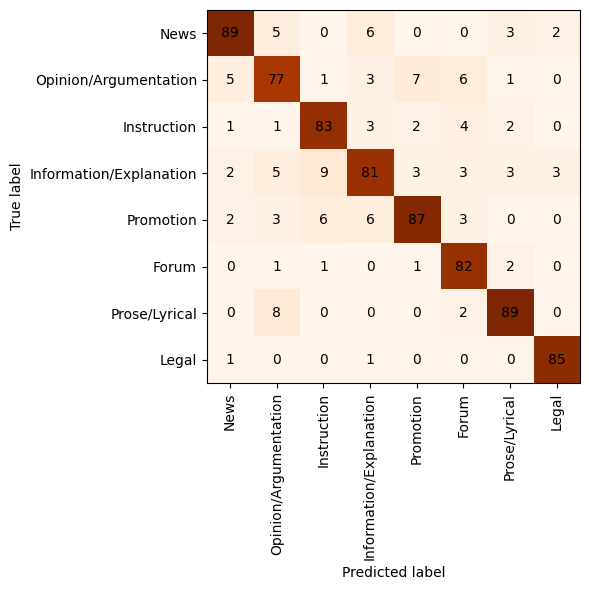

|                         |   precision |   recall |   f1-score |    support |
|:------------------------|------------:|---------:|-----------:|-----------:|
| Forum                   |    0.82     | 0.942529 |   0.877005 |  87        |
| Information/Explanation |    0.81     | 0.743119 |   0.77512  | 109        |
| Instruction             |    0.83     | 0.864583 |   0.846939 |  96        |
| Legal                   |    0.944444 | 0.977011 |   0.960452 |  87        |
| News                    |    0.89     | 0.847619 |   0.868293 | 105        |
| Opinion/Argumentation   |    0.77     | 0.77     |   0.77     | 100        |
| Promotion               |    0.87     | 0.813084 |   0.84058  | 107        |
| Prose/Lyrical           |    0.89     | 0.89899  |   0.894472 |  99        |
| accuracy                |    0.851899 | 0.851899 |   0.851899 |   0.851899 |
| macro avg               |    0.853056 | 0.857117 |   0.854108 | 790        |
| weighted avg            |    0.852059 | 0.851899 |

<Figure size 640x480 with 0 Axes>

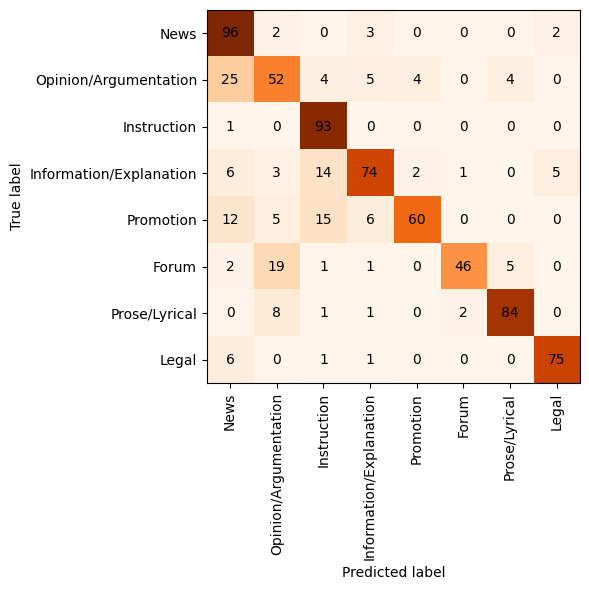

|                         |   precision |   recall |   f1-score |    support |
|:------------------------|------------:|---------:|-----------:|-----------:|
| Forum                   |    0.938776 | 0.528736 |   0.676471 |  87        |
| Information/Explanation |    0.813187 | 0.678899 |   0.74     | 109        |
| Instruction             |    0.72093  | 0.96875  |   0.826667 |  96        |
| Legal                   |    0.914634 | 0.862069 |   0.887574 |  87        |
| Mix                     |    0        | 0        |   0        |   0        |
| News                    |    0.648649 | 0.914286 |   0.758893 | 105        |
| Opinion/Argumentation   |    0.58427  | 0.52     |   0.550265 | 100        |
| Other                   |    0        | 0        |   0        |   0        |
| Promotion               |    0.909091 | 0.560748 |   0.693642 | 107        |
| Prose/Lyrical           |    0.903226 | 0.848485 |   0.875    |  99        |
| accuracy                |    0.734177 | 0.734177 |

/home/tajak/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tajak/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tajak/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<Figure size 640x480 with 0 Axes>

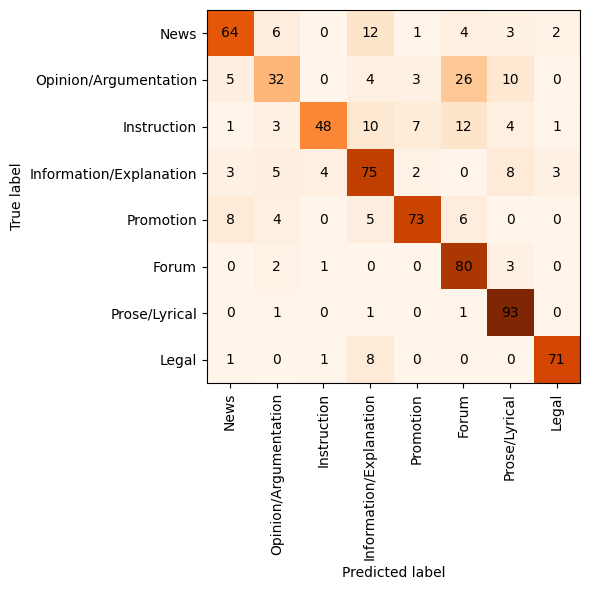

|                         |   precision |   recall |   f1-score |    support |
|:------------------------|------------:|---------:|-----------:|-----------:|
| Forum                   |    0.620155 | 0.91954  |   0.740741 |  87        |
| Information/Explanation |    0.652174 | 0.688073 |   0.669643 | 109        |
| Instruction             |    0.888889 | 0.5      |   0.64     |  96        |
| Legal                   |    0.922078 | 0.816092 |   0.865854 |  87        |
| Mix                     |    0        | 0        |   0        |   0        |
| News                    |    0.780488 | 0.609524 |   0.684492 | 105        |
| Opinion/Argumentation   |    0.603774 | 0.32     |   0.418301 | 100        |
| Other                   |    0        | 0        |   0        |   0        |
| Promotion               |    0.848837 | 0.682243 |   0.756477 | 107        |
| Prose/Lyrical           |    0.768595 | 0.939394 |   0.845455 |  99        |
| accuracy                |    0.678481 | 0.678481 |

/home/tajak/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tajak/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tajak/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<Figure size 640x480 with 0 Axes>

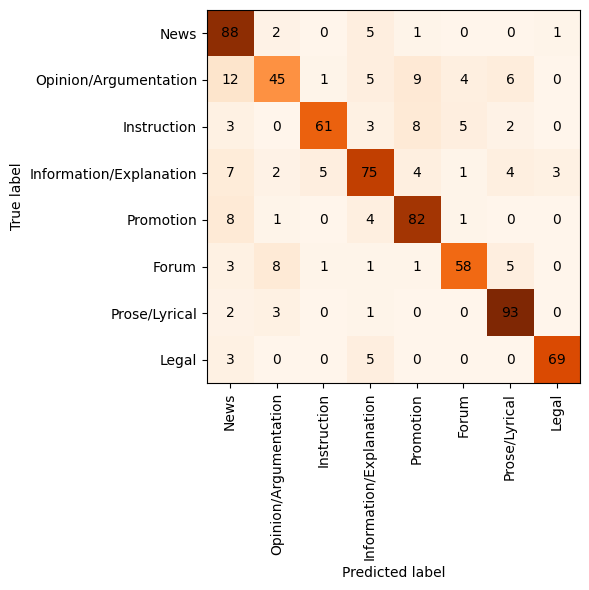

|                         |   precision |   recall |   f1-score |    support |
|:------------------------|------------:|---------:|-----------:|-----------:|
| Forum                   |    0.84058  | 0.666667 |   0.74359  |  87        |
| Information/Explanation |    0.757576 | 0.688073 |   0.721154 | 109        |
| Instruction             |    0.897059 | 0.635417 |   0.743902 |  96        |
| Legal                   |    0.945205 | 0.793103 |   0.8625   |  87        |
| Mix                     |    0        | 0        |   0        |   0        |
| News                    |    0.698413 | 0.838095 |   0.761905 | 105        |
| Opinion/Argumentation   |    0.737705 | 0.45     |   0.559006 | 100        |
| Other                   |    0        | 0        |   0        |   0        |
| Promotion               |    0.780952 | 0.766355 |   0.773585 | 107        |
| Prose/Lyrical           |    0.845455 | 0.939394 |   0.889952 |  99        |
| accuracy                |    0.722785 | 0.722785 |

/home/tajak/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tajak/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tajak/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<Figure size 640x480 with 0 Axes>

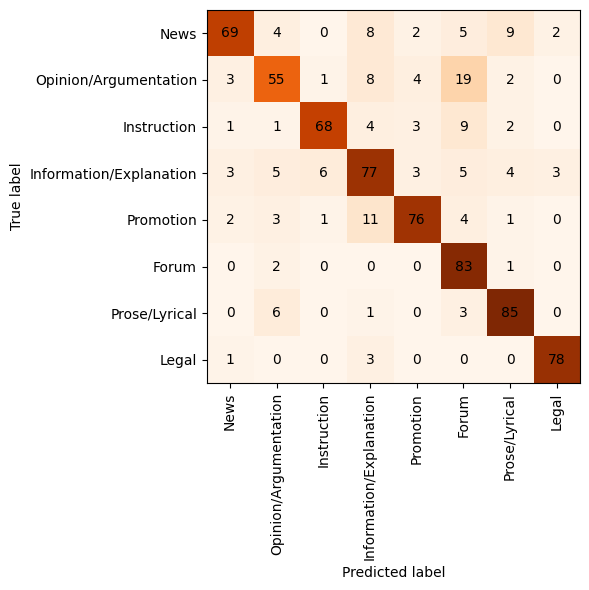

|                         |   precision |   recall |   f1-score |    support |
|:------------------------|------------:|---------:|-----------:|-----------:|
| Forum                   |    0.648438 | 0.954023 |   0.772093 |  87        |
| Information/Explanation |    0.6875   | 0.706422 |   0.696833 | 109        |
| Instruction             |    0.894737 | 0.708333 |   0.790698 |  96        |
| Legal                   |    0.939759 | 0.896552 |   0.917647 |  87        |
| Mix                     |    0        | 0        |   0        |   0        |
| News                    |    0.873418 | 0.657143 |   0.75     | 105        |
| Opinion/Argumentation   |    0.723684 | 0.55     |   0.625    | 100        |
| Other                   |    0        | 0        |   0        |   0        |
| Promotion               |    0.863636 | 0.71028  |   0.779487 | 107        |
| Prose/Lyrical           |    0.817308 | 0.858586 |   0.837438 |  99        |
| accuracy                |    0.748101 | 0.748101 |

/home/tajak/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tajak/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tajak/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<Figure size 640x480 with 0 Axes>

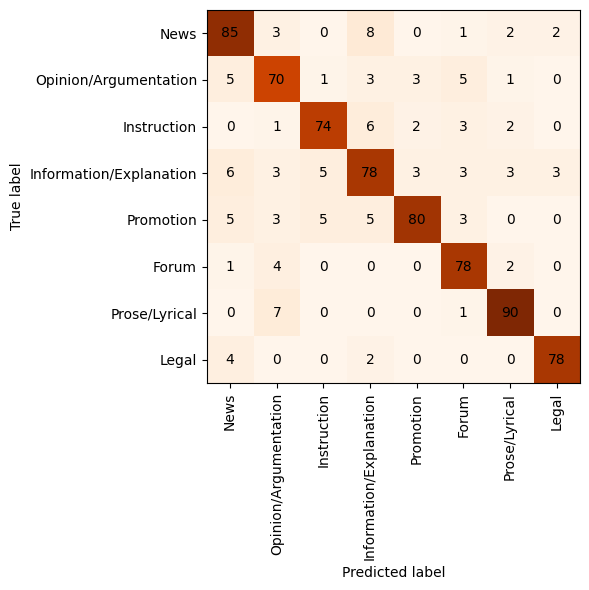

/home/tajak/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tajak/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tajak/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


|                         |   precision |   recall |   f1-score |    support |
|:------------------------|------------:|---------:|-----------:|-----------:|
| Forum                   |    0.829787 | 0.896552 |   0.861878 |  87        |
| Information/Explanation |    0.764706 | 0.715596 |   0.739336 | 109        |
| Instruction             |    0.870588 | 0.770833 |   0.81768  |  96        |
| Legal                   |    0.939759 | 0.896552 |   0.917647 |  87        |
| Mix                     |    0        | 0        |   0        |   0        |
| News                    |    0.801887 | 0.809524 |   0.805687 | 105        |
| Opinion/Argumentation   |    0.769231 | 0.7      |   0.732984 | 100        |
| Other                   |    0        | 0        |   0        |   0        |
| Promotion               |    0.909091 | 0.747664 |   0.820513 | 107        |
| Prose/Lyrical           |    0.9      | 0.909091 |   0.904523 |  99        |
| accuracy                |    0.801266 | 0.801266 |

<Figure size 640x480 with 0 Axes>

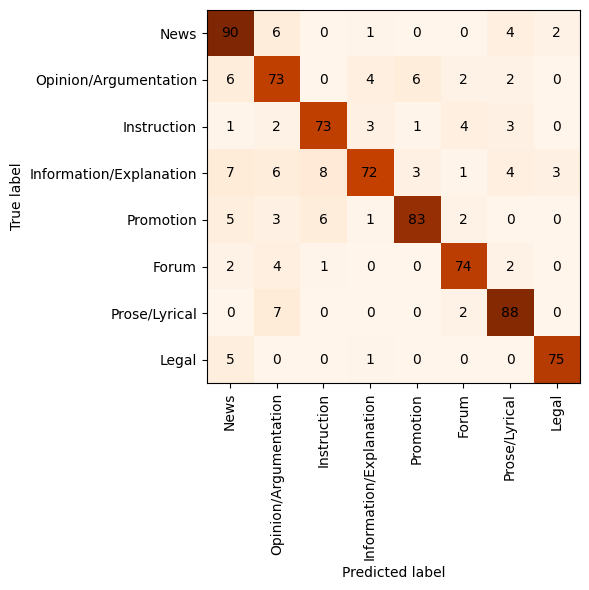

|                         |   precision |   recall |   f1-score |    support |
|:------------------------|------------:|---------:|-----------:|-----------:|
| Forum                   |    0.870588 | 0.850575 |   0.860465 |  87        |
| Information/Explanation |    0.878049 | 0.66055  |   0.753927 | 109        |
| Instruction             |    0.829545 | 0.760417 |   0.793478 |  96        |
| Legal                   |    0.9375   | 0.862069 |   0.898204 |  87        |
| Mix                     |    0        | 0        |   0        |   0        |
| News                    |    0.775862 | 0.857143 |   0.81448  | 105        |
| Opinion/Argumentation   |    0.722772 | 0.73     |   0.726368 | 100        |
| Other                   |    0        | 0        |   0        |   0        |
| Promotion               |    0.892473 | 0.775701 |   0.83     | 107        |
| Prose/Lyrical           |    0.854369 | 0.888889 |   0.871287 |  99        |
| accuracy                |    0.794937 | 0.794937 |

/home/tajak/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tajak/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tajak/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<Figure size 640x480 with 0 Axes>

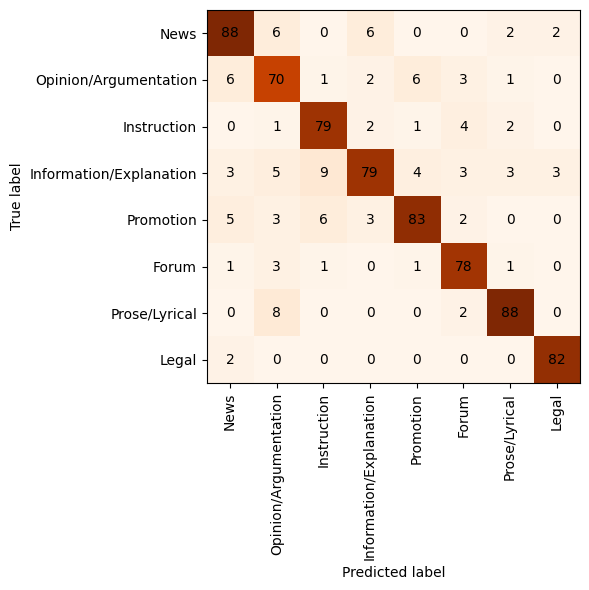

|                         |   precision |   recall |   f1-score |    support |
|:------------------------|------------:|---------:|-----------:|-----------:|
| Forum                   |    0.847826 | 0.896552 |   0.871508 |  87        |
| Information/Explanation |    0.858696 | 0.724771 |   0.78607  | 109        |
| Instruction             |    0.822917 | 0.822917 |   0.822917 |  96        |
| Legal                   |    0.942529 | 0.942529 |   0.942529 |  87        |
| Mix                     |    0        | 0        |   0        |   0        |
| News                    |    0.838095 | 0.838095 |   0.838095 | 105        |
| Opinion/Argumentation   |    0.729167 | 0.7      |   0.714286 | 100        |
| Other                   |    0        | 0        |   0        |   0        |
| Promotion               |    0.873684 | 0.775701 |   0.821782 | 107        |
| Prose/Lyrical           |    0.907216 | 0.888889 |   0.897959 |  99        |
| accuracy                |    0.818987 | 0.818987 |

/home/tajak/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tajak/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tajak/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<Figure size 640x480 with 0 Axes>

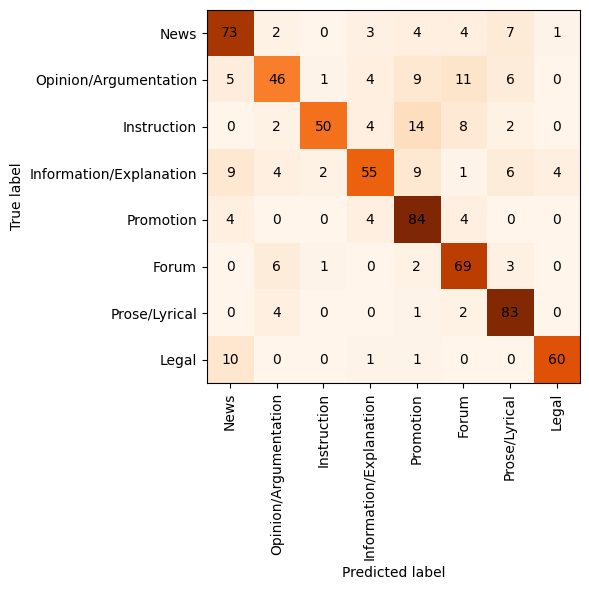

|                         |   precision |   recall |   f1-score |    support |
|:------------------------|------------:|---------:|-----------:|-----------:|
| Forum                   |    0.69697  | 0.793103 |   0.741935 |  87        |
| Information/Explanation |    0.774648 | 0.504587 |   0.611111 | 109        |
| Instruction             |    0.925926 | 0.520833 |   0.666667 |  96        |
| Legal                   |    0.923077 | 0.689655 |   0.789474 |  87        |
| Mix                     |    0        | 0        |   0        |   0        |
| News                    |    0.722772 | 0.695238 |   0.708738 | 105        |
| Opinion/Argumentation   |    0.71875  | 0.46     |   0.560976 | 100        |
| Other                   |    0        | 0        |   0        |   0        |
| Promotion               |    0.677419 | 0.785047 |   0.727273 | 107        |
| Prose/Lyrical           |    0.775701 | 0.838384 |   0.805825 |  99        |
| accuracy                |    0.658228 | 0.658228 |

/home/tajak/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tajak/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tajak/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<Figure size 640x480 with 0 Axes>

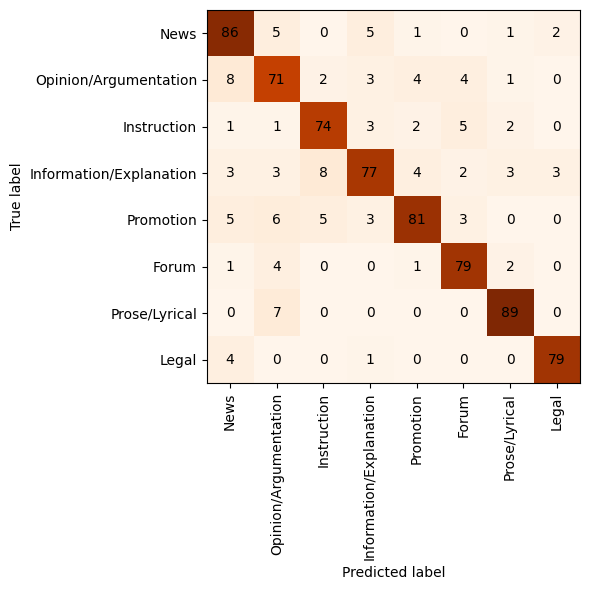

|                         |   precision |   recall |   f1-score |    support |
|:------------------------|------------:|---------:|-----------:|-----------:|
| Forum                   |    0.849462 | 0.908046 |   0.877778 |  87        |
| Information/Explanation |    0.836957 | 0.706422 |   0.766169 | 109        |
| Instruction             |    0.831461 | 0.770833 |   0.8      |  96        |
| Legal                   |    0.940476 | 0.908046 |   0.923977 |  87        |
| Mix                     |    0        | 0        |   0        |   0        |
| News                    |    0.796296 | 0.819048 |   0.807512 | 105        |
| Opinion/Argumentation   |    0.731959 | 0.71     |   0.720812 | 100        |
| Other                   |    0        | 0        |   0        |   0        |
| Promotion               |    0.870968 | 0.757009 |   0.81     | 107        |
| Prose/Lyrical           |    0.908163 | 0.89899  |   0.903553 |  99        |
| accuracy                |    0.805063 | 0.805063 |

/home/tajak/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tajak/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tajak/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<Figure size 640x480 with 0 Axes>

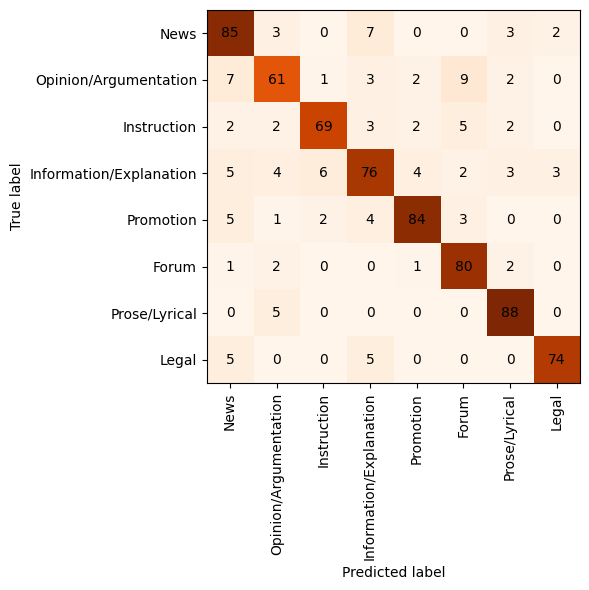

|                         |   precision |   recall |   f1-score |    support |
|:------------------------|------------:|---------:|-----------:|-----------:|
| Forum                   |    0.808081 | 0.91954  |   0.860215 |  87        |
| Information/Explanation |    0.77551  | 0.697248 |   0.7343   | 109        |
| Instruction             |    0.884615 | 0.71875  |   0.793103 |  96        |
| Legal                   |    0.936709 | 0.850575 |   0.891566 |  87        |
| Mix                     |    0        | 0        |   0        |   0        |
| News                    |    0.772727 | 0.809524 |   0.790698 | 105        |
| Opinion/Argumentation   |    0.782051 | 0.61     |   0.685393 | 100        |
| Other                   |    0        | 0        |   0        |   0        |
| Promotion               |    0.903226 | 0.785047 |   0.84     | 107        |
| Prose/Lyrical           |    0.88     | 0.888889 |   0.884422 |  99        |
| accuracy                |    0.781013 | 0.781013 |

/home/tajak/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tajak/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tajak/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<Figure size 640x480 with 0 Axes>

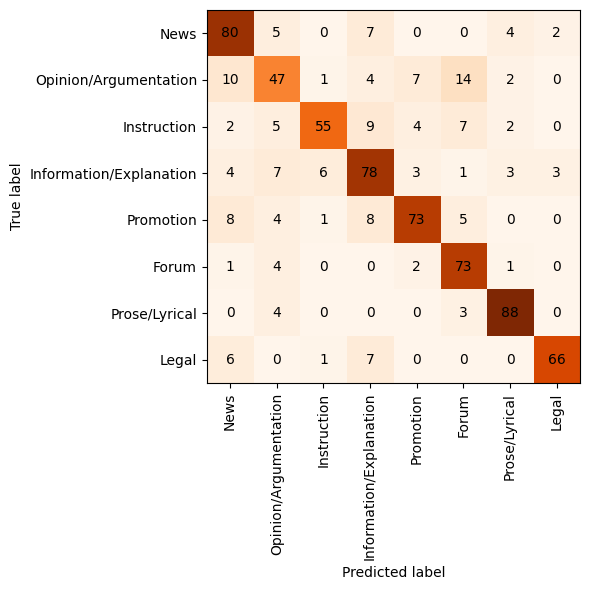

|                         |   precision |   recall |   f1-score |    support |
|:------------------------|------------:|---------:|-----------:|-----------:|
| Forum                   |    0.708738 | 0.83908  |   0.768421 |  87        |
| Information/Explanation |    0.690265 | 0.715596 |   0.702703 | 109        |
| Instruction             |    0.859375 | 0.572917 |   0.6875   |  96        |
| Legal                   |    0.929577 | 0.758621 |   0.835443 |  87        |
| Mix                     |    0        | 0        |   0        |   0        |
| News                    |    0.720721 | 0.761905 |   0.740741 | 105        |
| Opinion/Argumentation   |    0.618421 | 0.47     |   0.534091 | 100        |
| Other                   |    0        | 0        |   0        |   0        |
| Promotion               |    0.820225 | 0.682243 |   0.744898 | 107        |
| Prose/Lyrical           |    0.88     | 0.888889 |   0.884422 |  99        |
| accuracy                |    0.708861 | 0.708861 |

/home/tajak/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tajak/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tajak/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<Figure size 640x480 with 0 Axes>

In [29]:
results = {}

for column in ["y_pred", 'translation-pred', 'shuffled-text-pred', 'text_no_punct-pred', 'text_no_capital-pred', 'text_no_capital_rand-pred', 'text_no_num-pred', 'text_no_num_rand-pred', 'text_no_structure-pred', 'text_random_removal_10-pred', 'text_random_removal_25-pred', 'text_random_removal_50-pred']:
	print(column)
	print("\n\n")
	y_pred = df[column].to_list()
	y_true = df["y_true"].to_list()
	labels = list(df["y_true"].unique())

	current_result = testing(y_true, y_pred, labels, show_matrix=True)

	print(current_result)

	current_dict = {}
	current_dict["macro_F1"] = current_result["macro F1"]

	for label in labels:
		try:
			current_dict[f"{label}_F1"] = current_result["report"][label]["f1-score"]
		except:
			continue

	results[column] = current_dict
	print("---------------")

In [31]:
results_df = pd.DataFrame(results)

results_df

,y_pred,translation-pred,shuffled-text-pred,text_no_punct-pred,text_no_capital-pred,text_no_capital_rand-pred,text_no_num-pred,text_no_num_rand-pred,text_no_structure-pred,text_random_removal_10-pred,text_random_removal_25-pred,text_random_removal_50-pred
macro_F1,0.854108,0.751064,0.702620,0.756949,0.771149,0.825031,0.818526,0.836893,0.701500,0.826225,0.809962,0.737277
News_F1,0.868293,0.758893,0.684492,0.761905,0.750000,0.805687,0.814480,0.838095,0.708738,0.807512,0.790698,0.740741
Opinion/Argumentation_F1,0.770000,0.550265,0.418301,0.559006,0.625000,0.732984,0.726368,0.714286,0.560976,0.720812,0.685393,0.534091
Instruction_F1,0.846939,0.826667,0.640000,0.743902,0.790698,0.817680,0.793478,0.822917,0.666667,0.800000,0.793103,0.687500
Information/Explanation_F1,0.775120,0.740000,0.669643,0.721154,0.696833,0.739336,0.753927,0.786070,0.611111,0.766169,0.734300,0.702703
Promotion_F1,0.840580,0.693642,0.756477,0.773585,0.779487,0.820513,0.830000,0.821782,0.727273,0.810000,0.840000,0.744898
Forum_F1,0.877005,0.676471,0.740741,0.743590,0.772093,0.861878,0.860465,0.871508,0.741935,0.877778,0.860215,0.768421
Prose/Lyrical_F1,0.894472,0.875000,0.845455,0.889952,0.837438,0.904523,0.871287,0.897959,0.805825,0.903553,0.884422,0.884422
Legal_F1,0.960452,0.887574,0.865854,0.862500,0.917647,0.917647,0.898204,0.942529,0.789474,0.923977,0.891566,0.835443


In [37]:
results_df.columns

Index(['y_pred', 'translation-pred', 'shuffled-text-pred',
       'text_no_punct-pred', 'text_no_capital-pred',
       'text_no_capital_rand-pred', 'text_no_num-pred',
       'text_no_num_rand-pred', 'text_no_structure-pred',
       'text_random_removal_10-pred', 'text_random_removal_25-pred',
       'text_random_removal_50-pred', 'translation-change'],
      dtype='object')

In [38]:
for column in ['translation-pred', 'shuffled-text-pred',
       'text_no_punct-pred', 'text_no_capital-pred', 'text_no_num-pred', 'text_no_structure-pred', 'text_random_removal_10-pred', 'text_random_removal_25-pred',
       'text_random_removal_50-pred']:
	results_df[f"{column}-vs-y_pred"] = (results_df[f"{column}"] - results_df["y_pred"])/results_df["y_pred"]*100

for column in ['text_no_capital-pred']:
	results_df[f"{column}-vs-text_no_capital_rand-pred"] = (results_df[f"{column}"] - results_df["text_no_capital_rand-pred"])/results_df["text_no_capital_rand-pred"]*100

for column in ['text_no_num-pred', 'text_no_structure-pred']:
	results_df[f"{column}-vs-text_no_num_rand-pred"] = (results_df[f"{column}"] - results_df['text_no_num_rand-pred'])/results_df['text_no_num_rand-pred']*100

In [46]:
for column in ['translation-pred', 'shuffled-text-pred',
       'text_no_punct-pred', 'text_no_capital-pred', 'text_no_num-pred', 'text_no_structure-pred', 'text_random_removal_10-pred', 'text_random_removal_25-pred',
       'text_random_removal_50-pred']:
	results_df[f"{column}-vs-y_pred"] = results_df[f"{column}"] - results_df["y_pred"]

for column in ['text_no_capital-pred']:
	results_df[f"{column}-vs-text_no_capital_rand-pred"] = results_df[f"{column}"] - results_df["text_no_capital_rand-pred"]

for column in ['text_no_num-pred', 'text_no_structure-pred']:
	results_df[f"{column}-vs-text_no_num_rand-pred"] = results_df[f"{column}"] - results_df['text_no_num_rand-pred']

In [47]:
results_df.columns

Index(['y_pred', 'translation-pred', 'shuffled-text-pred',
       'text_no_punct-pred', 'text_no_capital-pred',
       'text_no_capital_rand-pred', 'text_no_num-pred',
       'text_no_num_rand-pred', 'text_no_structure-pred',
       'text_random_removal_10-pred', 'text_random_removal_25-pred',
       'text_random_removal_50-pred', 'translation-change',
       'translation-pred-vs-y_pred', 'shuffled-text-pred-vs-y_pred',
       'text_no_punct-pred-vs-y_pred', 'text_no_capital-pred-vs-y_pred',
       'text_no_num-pred-vs-y_pred', 'text_no_structure-pred-vs-y_pred',
       'text_random_removal_10-pred-vs-y_pred',
       'text_random_removal_25-pred-vs-y_pred',
       'text_random_removal_50-pred-vs-y_pred',
       'text_no_capital-pred-vs-text_no_capital_rand-pred',
       'text_no_num-pred-vs-text_no_num_rand-pred',
       'text_no_structure-pred-vs-text_no_num_rand-pred'],
      dtype='object')

In [48]:
final_results = results_df[['y_pred', 'translation-pred','translation-pred-vs-y_pred', 'shuffled-text-pred', 'shuffled-text-pred-vs-y_pred',
       'text_no_punct-pred', 'text_no_punct-pred-vs-y_pred', 'text_no_capital-pred', 'text_no_capital_rand-pred', 'text_no_capital-pred-vs-y_pred', 'text_no_capital-pred-vs-text_no_capital_rand-pred',
        'text_no_num-pred', 'text_no_num_rand-pred', 'text_no_num-pred-vs-y_pred', 'text_no_num-pred-vs-text_no_num_rand-pred', 'text_no_structure-pred','text_no_structure-pred-vs-y_pred', 'text_no_structure-pred-vs-text_no_num_rand-pred',
       'text_random_removal_10-pred','text_random_removal_10-pred-vs-y_pred', 'text_random_removal_25-pred','text_random_removal_25-pred-vs-y_pred',
       'text_random_removal_50-pred','text_random_removal_50-pred-vs-y_pred',]].transpose()

final_results

,macro_F1,News_F1,Opinion/Argumentation_F1,Instruction_F1,Information/Explanation_F1,Promotion_F1,Forum_F1,Prose/Lyrical_F1,Legal_F1
y_pred,0.854108,0.868293,0.770000,0.846939,0.775120,0.840580,0.877005,0.894472,0.960452
translation-pred,0.751064,0.758893,0.550265,0.826667,0.740000,0.693642,0.676471,0.875000,0.887574
translation-pred-vs-y_pred,-0.103044,-0.109399,-0.219735,-0.020272,-0.035120,-0.146938,-0.200535,-0.019472,-0.072878
shuffled-text-pred,0.702620,0.684492,0.418301,0.640000,0.669643,0.756477,0.740741,0.845455,0.865854
shuffled-text-pred-vs-y_pred,-0.151487,-0.183801,-0.351699,-0.206939,-0.105477,-0.084103,-0.136265,-0.049018,-0.094598
text_no_punct-pred,0.756949,0.761905,0.559006,0.743902,0.721154,0.773585,0.743590,0.889952,0.862500
text_no_punct-pred-vs-y_pred,-0.097158,-0.106388,-0.210994,-0.103036,-0.053966,-0.066995,-0.133416,-0.004520,-0.097952
text_no_capital-pred,0.771149,0.750000,0.625000,0.790698,0.696833,0.779487,0.772093,0.837438,0.917647
text_no_capital_rand-pred,0.825031,0.805687,0.732984,0.817680,0.739336,0.820513,0.861878,0.904523,0.917647
text_no_capital-pred-vs-y_pred,-0.082958,-0.118293,-0.145000,-0.056241,-0.078287,-0.061093,-0.104912,-0.057034,-0.042805


In [49]:
print(final_results.to_markdown())

|                                                   |   macro_F1 |    News_F1 |   Opinion/Argumentation_F1 |   Instruction_F1 |   Information/Explanation_F1 |   Promotion_F1 |    Forum_F1 |   Prose/Lyrical_F1 |   Legal_F1 |
|:--------------------------------------------------|-----------:|-----------:|---------------------------:|-----------------:|-----------------------------:|---------------:|------------:|-------------------:|-----------:|
| y_pred                                            |  0.854108  |  0.868293  |                  0.77      |        0.846939  |                   0.77512    |     0.84058    |  0.877005   |         0.894472   |  0.960452  |
| translation-pred                                  |  0.751064  |  0.758893  |                  0.550265  |        0.826667  |                   0.74       |     0.693642   |  0.676471   |         0.875      |  0.887574  |
| translation-pred-vs-y_pred                        | -0.103044  | -0.109399  |                 -0.21973

In [ ]:
final_results

## Calculating F1 scores for each case

In [7]:
import json
import pandas as pd

In [8]:
# Import the dataset
# Import the final dataset with test sets
with open("manual-annotations/multilingual-genre-annotated-test-set.json") as main_file:
	main_dict = json.load(main_file)

main_dict.keys()

dict_keys(['mt', 'el', 'tr', 'sq', 'is', 'uk', 'ca', 'mk', 'hr', 'sl'])

In [10]:
# Open the test set
df = pd.read_csv("datasets/adversarial-analysis/merged-test-sets-for-adversarial-analysis.csv", index_col=0)
df.head(2)

,test_set,text_id,y_pred,y_true,text,translation,shuffled-text,text_no_punct,text_no_capital,text_no_capital_rand,...,text_no_capital_rand-pred,text_no_num-pred,text_no_num_rand-pred,text_no_structure-pred,text_random_removal_10,text_random_removal_25,text_random_removal_50,text_random_removal_10-pred,text_random_removal_25-pred,text_random_removal_50-pred
0,mt,macocu.mt.402244,News,News,"Angelo Chetcuti, se jkun qed jieħu post Bjorn ...","Angelo Chetcuti, will be replacing Bjorn Vassa...","wara stqarrija, wara sar tiegħu Chetcuti, fis-...",Angelo Chetcuti se jkun qed jieħu post Bjorn V...,se jkun qed jieħu post bħala segretarju ġenera...,"Chetcuti, jkun qed post Bjorn bħala ġenerali A...",...,Forum,News,News,Prose/Lyrical,"Angelo Chetcuti, se jkun qed jieħu post Bjorn ...","Angelo Chetcuti, se jieħu post Bjorn Vassallo ...",Angelo se qed jieħu post ġenerali Football dan...,News,News,News
1,mt,macocu.mt.377203,Prose/Lyrical,Opinion/Argumentation,Poltergeist jirreferi għal fenomeni oħra tal-m...,"Poltergeist refers to other woman's phenomena,...",per Wara tara xi viżibbli jew dawn. sitwazzjon...,Poltergeist jirreferi għal fenomeni oħra tal-m...,"jirreferi għal fenomeni oħra tal-mara, spirti,...","Poltergeist jirreferi għal oħra tal-mara, spir...",...,Prose/Lyrical,Prose/Lyrical,Prose/Lyrical,Prose/Lyrical,"Poltergeist jirreferi għal oħra tal-mara, spir...",Poltergeist jirreferi għal fenomeni oħra tal-m...,"jirreferi għal fenomeni oħra spirti, goblins, ...",Prose/Lyrical,Prose/Lyrical,Mix


In [11]:
main_dict["mt"].keys()

dict_keys(['accuracy', 'micro_f1', 'macro_f1', 'label_scores', 'dataset', 'token_overlap', 'English_word_overlap'])

In [6]:
df.columns

Index(['test_set', 'text_id', 'y_pred', 'y_true', 'text', 'translation',
       'shuffled-text', 'text_no_punct', 'text_no_capital',
       'text_no_capital_rand', 'text_no_num', 'text_no_num_rand',
       'text_no_structure', 'translation-pred', 'shuffled-text-pred',
       'text_no_punct-pred', 'text_no_capital-pred',
       'text_no_capital_rand-pred', 'text_no_num-pred',
       'text_no_num_rand-pred', 'text_no_structure-pred',
       'text_random_removal_10', 'text_random_removal_25',
       'text_random_removal_50', 'text_random_removal_10-pred',
       'text_random_removal_25-pred', 'text_random_removal_50-pred'],
      dtype='object')

In [ ]:
from evaluation import testing

results_dict = {}

for lang in list(main_dict.keys()):
	lang_df = df[df["test_set"] == lang]
	lang_results_dict = {}
	for column in ['translation-pred', 'shuffled-text-pred',
       'text_no_punct-pred', 'text_no_capital-pred',
       'text_no_capital_rand-pred', 'text_no_num-pred',
       'text_no_num_rand-pred', 'text_no_structure-pred', 'text_random_removal_10-pred',
       'text_random_removal_25-pred', 'text_random_removal_50-pred']:
		y_pred = lang_df[column].to_list()
		y_true = lang_df["y_true"].to_list()
		labels = list(lang_df["y_true"].unique())

		current_result = testing(y_true, y_pred, labels, show_matrix=False)

		lang_results_dict[f"{column}"] = current_result
	
	results_dict[lang] = lang_results_dict


In [10]:
# Save results dict
with open("datasets/adversarial-analysis/adversarial-analysis-F1-scores.json", "w") as f:
	json.dump(results_dict, f)

In [12]:
with open("datasets/adversarial-analysis/adversarial-analysis-F1-scores.json", "r") as f:
	results_dict = json.load(f)

In [13]:
results_dict

{'mt': {'translation-pred': {'accuracy': 0.6714285714285714,
   'micro F1': 0.6861313868613139,
   'macro F1': 0.42215632248322665,
   'report': {'Forum': {'precision': 0.0,
     'recall': 0.0,
     'f1-score': 0.0,
     'support': 1.0},
    'Information/Explanation': {'precision': 0.6,
     'recall': 0.46153846153846156,
     'f1-score': 0.5217391304347826,
     'support': 13.0},
    'Instruction': {'precision': 0.7037037037037037,
     'recall': 1.0,
     'f1-score': 0.8260869565217391,
     'support': 19.0},
    'Mix': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 0.0},
    'News': {'precision': 0.8421052631578947,
     'recall': 1.0,
     'f1-score': 0.9142857142857143,
     'support': 16.0},
    'Opinion/Argumentation': {'precision': 0.25,
     'recall': 0.125,
     'f1-score': 0.16666666666666666,
     'support': 8.0},
    'Other': {'precision': 0.0,
     'recall': 0.0,
     'f1-score': 0.0,
     'support': 0.0},
    'Promotion': {'precision': 0.7142857142857143,


In [17]:
main_dict["mt"]['macro_f1']

0.4884076443296833

In [19]:
all_langs_results = {}

for lang in list(results_dict.keys()):
	lang_results = {}
	lang_results["y_pred"] = main_dict[lang]['macro_f1']
	# Add macro F1 score from main dict
	for scenario in list(results_dict[lang].keys()):
		lang_results[scenario] = results_dict[lang][scenario]["macro F1"] 
	all_langs_results[lang] = lang_results

langs_results_df = pd.DataFrame(all_langs_results).transpose()
langs_results_df

,y_pred,translation-pred,shuffled-text-pred,text_no_punct-pred,text_no_capital-pred,text_no_capital_rand-pred,text_no_num-pred,text_no_num_rand-pred,text_no_structure-pred,text_random_removal_10-pred,text_random_removal_25-pred,text_random_removal_50-pred
mt,0.488408,0.422156,0.282766,0.312440,0.170630,0.391458,0.391186,0.447375,0.155462,0.386164,0.349852,0.292631
el,0.843560,0.667432,0.634038,0.690398,0.843606,0.787623,0.738104,0.773042,0.719132,0.768054,0.761652,0.719467
tr,0.899063,0.810064,0.784729,0.857738,0.823153,0.874779,0.904728,0.915753,0.798306,0.908369,0.874136,0.772016
sq,0.854073,0.742894,0.729750,0.724246,0.796639,0.852999,0.799112,0.838429,0.733799,0.847583,0.756209,0.705111
is,0.795338,0.643434,0.718404,0.762613,0.728155,0.771304,0.807630,0.796652,0.785274,0.790168,0.796429,0.751780
uk,0.948327,0.774705,0.711248,0.831048,0.860035,0.932738,0.938276,0.944855,0.737303,0.939444,0.935534,0.801742
ca,0.827101,0.760178,0.734360,0.742799,0.748809,0.782302,0.799811,0.774592,0.733405,0.777462,0.766287,0.734581
mk,0.922638,0.772557,0.669621,0.764548,0.793859,0.885162,0.855417,0.896935,0.664989,0.854036,0.840788,0.743159
hr,0.882916,0.789453,0.759024,0.843166,0.891885,0.873639,0.887325,0.868526,0.781763,0.862531,0.866256,0.781509
sl,0.935625,0.778775,0.799215,0.801340,0.875271,0.913574,0.891845,0.940920,0.711017,0.916005,0.927762,0.827121


In [20]:

for column in ['translation-pred', 'shuffled-text-pred',
       'text_no_punct-pred', 'text_no_capital-pred', 'text_no_num-pred', 'text_no_structure-pred', 'text_random_removal_10-pred', 'text_random_removal_25-pred',
       'text_random_removal_50-pred']:
	langs_results_df[f"{column}-vs-y_pred"] = langs_results_df[f"{column}"] - langs_results_df["y_pred"]

for column in ['text_no_capital-pred']:
	langs_results_df[f"{column}-vs-text_no_capital_rand-pred"] = langs_results_df[f"{column}"] - langs_results_df["text_no_capital_rand-pred"]

for column in ['text_no_num-pred', 'text_no_structure-pred']:
	langs_results_df[f"{column}-vs-text_no_num_rand-pred"] = langs_results_df[f"{column}"] - langs_results_df['text_no_num_rand-pred']

final_lang_results = langs_results_df[['y_pred', 'translation-pred','translation-pred-vs-y_pred', 'shuffled-text-pred', 'shuffled-text-pred-vs-y_pred',
       'text_no_punct-pred', 'text_no_punct-pred-vs-y_pred', 'text_no_capital-pred', 'text_no_capital_rand-pred', 'text_no_capital-pred-vs-y_pred', 'text_no_capital-pred-vs-text_no_capital_rand-pred',
        'text_no_num-pred', 'text_no_num_rand-pred', 'text_no_num-pred-vs-y_pred', 'text_no_num-pred-vs-text_no_num_rand-pred', 'text_no_structure-pred','text_no_structure-pred-vs-y_pred', 'text_no_structure-pred-vs-text_no_num_rand-pred',
       'text_random_removal_10-pred','text_random_removal_10-pred-vs-y_pred', 'text_random_removal_25-pred','text_random_removal_25-pred-vs-y_pred',
       'text_random_removal_50-pred','text_random_removal_50-pred-vs-y_pred',]].transpose()

final_lang_results

,mt,el,tr,sq,is,uk,ca,mk,hr,sl
y_pred,0.488408,0.843560,0.899063,0.854073,0.795338,0.948327,0.827101,0.922638,0.882916,0.935625
translation-pred,0.422156,0.667432,0.810064,0.742894,0.643434,0.774705,0.760178,0.772557,0.789453,0.778775
translation-pred-vs-y_pred,-0.066251,-0.176128,-0.088999,-0.111179,-0.151904,-0.173623,-0.066923,-0.150081,-0.093463,-0.156850
shuffled-text-pred,0.282766,0.634038,0.784729,0.729750,0.718404,0.711248,0.734360,0.669621,0.759024,0.799215
shuffled-text-pred-vs-y_pred,-0.205641,-0.209522,-0.114334,-0.124323,-0.076934,-0.237079,-0.092741,-0.253017,-0.123892,-0.136410
text_no_punct-pred,0.312440,0.690398,0.857738,0.724246,0.762613,0.831048,0.742799,0.764548,0.843166,0.801340
text_no_punct-pred-vs-y_pred,-0.175968,-0.153162,-0.041325,-0.129827,-0.032726,-0.117279,-0.084302,-0.158090,-0.039750,-0.134285
text_no_capital-pred,0.170630,0.843606,0.823153,0.796639,0.728155,0.860035,0.748809,0.793859,0.891885,0.875271
text_no_capital_rand-pred,0.391458,0.787623,0.874779,0.852999,0.771304,0.932738,0.782302,0.885162,0.873639,0.913574
text_no_capital-pred-vs-y_pred,-0.317778,0.000046,-0.075911,-0.057434,-0.067184,-0.088292,-0.078292,-0.128779,0.008969,-0.060354


In [21]:
print(final_lang_results.to_markdown())

|                                                   |         mt |           el |          tr |          sq |          is |          uk |         ca |         mk |          hr |          sl |
|:--------------------------------------------------|-----------:|-------------:|------------:|------------:|------------:|------------:|-----------:|-----------:|------------:|------------:|
| y_pred                                            |  0.488408  |  0.84356     |  0.899063   |  0.854073   |  0.795338   |  0.948327   |  0.827101  |  0.922638  |  0.882916   |  0.935625   |
| translation-pred                                  |  0.422156  |  0.667432    |  0.810064   |  0.742894   |  0.643434   |  0.774705   |  0.760178  |  0.772557  |  0.789453   |  0.778775   |
| translation-pred-vs-y_pred                        | -0.0662513 | -0.176128    | -0.0889991  | -0.111179   | -0.151904   | -0.173623   | -0.066923  | -0.150081  | -0.0934629  | -0.15685    |
| shuffled-text-pred                    